In [26]:
# Import all necessary packages to run functions
from pathlib import Path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from FlowCytometryTools import FCMeasurement
from FlowCytometryTools import QuadGate, ThresholdGate
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
import seaborn as sns
from seaborn import relplot


def importF(pathname):
    """
    Import FCS files. Variable input: name of path name to file. Output is a list of Data File Names in FCT Format
    Title/file names are returned in the array file --> later referenced in other functions as title/titles input argument
    """
    # Declare arrays and int
    file = []
    sample = []
    title = []
    z = 0
    # Read in user input for file path and assign to array file
    pathlist = Path(r"" + str(pathname)).glob("**/*.fcs")
    for path in pathlist:
        path_in_str = str(path)
        file.append(path_in_str)
    file.sort()
    # Go through each file and assign the file contents to entry in the array sample
    for entry in file:
        sample.append(FCMeasurement(ID="Test Sample" + str(z), datafile=entry))
        z += 1
    importF.sample = sample
    # Returns the array sample which contains data of each file in folder (one file per entry in array)
    return sample, file


def sampleT(smpl):
    """Output is the T cells data (the protein channels related to T cells)"""
    # Features are the protein channels of interest when analyzing T cells
    features = ["BL1-H", "VL1-H", "VL4-H", "BL3-H"]
    # Transform to put on log scale
    tform = smpl.transform("hlog", channels=["BL1-H", "VL1-H", "VL4-H", "BL3-H", "RL1-H"])
    # Save the data of each column of the protein channels
    data = tform.data[["BL1-H", "VL1-H", "VL4-H", "BL3-H"]][0:]
    # Save pSTAT5 data
    pstat = tform.data[["RL1-H"]][0:]
    return data, pstat, features


def sampleNK(smpl):
    """Output is the NK cells data (the protein channels related to NK cells)"""
    # For NK, the data consists of different channels so the data var. output will be different
    # Output is data specific to NK cells
    # Features for the NK file of proteins (CD3, CD8, CD56)
    features = ["VL4-H", "RL1-H", "BL1-H"]
    # Transform all proteins (including pSTAT5)
    tform = smpl.transform("hlog", channels=["VL4-H", "RL1-H", "BL1-H", "BL2-H"])
    # Assign data of three protein channels AND pSTAT5
    data = tform.data[["VL4-H", "RL1-H", "BL1-H"]][0:]
    pstat = tform.data[["BL2-H"]][0:]
    return data, pstat, features


def appPCA(data, features):
    """Applies the PCA algorithm to the data set"""
    # Apply PCA to the data set
    # setting values of data of selected features to data frame
    xi = data.loc[:, features].values
    # STANDARDIZE DATA --> very important to do before applying machine learning algorithm
    scaler = preprocessing.StandardScaler()
    xs = scaler.fit_transform(xi)
    #xs = sklearn.preprocessing.scale(xi)
    xs = np.nan_to_num(xs)
    # setting how many components wanted --> PC1 and PC2
    pca = PCA(n_components=2)
    # apply PCA to standardized data set
    # NOTE: score == xf
    xf = pca.fit(xs).transform(xs)
    # creates the loading array (equation is defintion of loading)
    loading = pca.components_.T
    return xf, loading


def pcaPlt(xf, pstat, features, i, title):
    """
    Used to plot the score graph.
    Scattered point color gradients are based on range/abundance of pSTAT5 data. Light --> Dark = Less --> More Active
    """
    # PCA
    if len(features) == 4:
        name = "T Cells"
    elif len(features) == 3:
        name = "NK Cells"
    # Setting x and y values from xf
    x = xf[:, 0]
    y = xf[:, 1]
    pstat_data = pstat.values
    # Creating a figure for both scatter and mesh plots for PCA
    # This is the scatter plot of the cell clusters colored by pSTAT5 data
    # lighter --> darker = less --> more pSTAT5 present
    pstat = np.squeeze(pstat_data)
    #scale = min(pstat)
    #for z, _ in enumerate(pstat):
    #    pstat[z] = pstat[z] - scale
    pstat_mean = np.mean(pstat)
    print("mean pStat activity: ", pstat_mean)
    combined = np.stack((x, y, pstat)).T
    df = pd.DataFrame(combined, columns = ["PC1","PC2", "pSTAT5"])
    
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_title(name + " - PCA - " + str(title), fontsize=20)
    plt.xlim(-4, 6)
    plt.ylim(-4, 4)
    fig = sns.scatterplot(x="PC1", y="PC2", hue = "pSTAT5", palette="viridis", data=df, s = 5, ax = ax, legend = False, hue_norm = (3000, 7000));
    #print(plt.get_size_pixel(fig))
    ax.set_xlabel("PC1", fontsize=15)
    ax.set_ylabel("PC2", fontsize=15)
    #plt.savefig('pca_plots.png')
    
    points = plt.scatter(df["PC1"], df["PC2"], c=df["pSTAT5"], s=0, cmap="viridis",  vmin = 3000, vmax = 7000) #set style options
    plt.colorbar(points)
    
    
    
def loadingPlot(loading, features, i, title):
    """Plot the loading data"""
    # Loading
    # Create graph for loading values
    x_load = loading[:, 0]
    y_load = loading[:, 1]

    # Create figure for the loading plot
    fig1 = plt.figure(figsize=(8, 8))
    ax = fig1.add_subplot(1, 1, 1)
    ax.set_xlabel("PC1", fontsize=15)
    ax.set_ylabel("PC2", fontsize=15)
    plt.scatter(x_load, y_load)

    for z, feature in enumerate(features):
        # Please note: not the best logic, but there are three features in NK and four features in T cells
        if len(features) == 4:
            name = "T Cells"
            if feature == "BL1-H":
                feature = "Foxp3"
            elif feature == "VL1-H":
                feature = "CD25"
            elif feature == "VL4-H":
                feature = "CD4"
            elif feature == "BL3-H":
                feature = "CD45RA"
        if len(features) == 3:
            name = "NK Cells"
            if feature == "VL4-H":
                feature = "CD3"
            if feature == "RL1-H":
                feature = "CD8"
            if feature == "BL1-H":
                feature = "CD56"
        plt.annotate(str(feature), xy=(x_load[z], y_load[z]))
    ax.set_title(name + " - Loading - " + str(title), fontsize=20)
    
    
def pcaAll(sampleType, check, titles):
    """
    Use to plot the score and loading graphs for PCA. Assign protein and pstat5 arrays AND score and loading arrays
    This is all the data for each file.
    Want to use for both T and NK cells? Use it twice!
    sampleType is importF for T or NK
    check == "t" for T cells OR check == "n" for NK cells
    """
    # declare the arrays to store the data
    data_array = []
    pstat_array = []
    xf_array = []
    loading_array = []
    
    # create the for loop to file through the data and save to the arrays
    # using the functions created above for a singular file
    if check == "t":
        for i, sample in enumerate(sampleType):
            title = titles[i].split("/")
            title = title[len(title)-1]
            data, pstat, features = sampleT(sample)
            data_array.append(data)
            pstat_array.append(pstat)
            xf, loading = appPCA(data, features)
            xf_array.append(xf)
            loading_array.append(loading)
            pcaPlt(xf, pstat, features, i, title)
            loadingPlot(loading, features, i, title)
            #plt.scatter(data)
    elif check == "n":
        for i, sample in enumerate(sampleType):
            title = titles[i].split("/")
            title = title[len(title)-1]
            data, pstat, features = sampleNK(sample)
            data_array.append(data)
            pstat_array.append(pstat)
            xf, loading = appPCA(data, features)
            pcaPlt(xf, pstat, features, i, title)
            loadingPlot(loading, features, i, title)
    plt.show()
    return data_array, pstat_array, xf_array, loading_array

def count_data(sampleType, gate):
    """
    Used to count the number of cells and store the data of all of these cells in a folder with multiple files --> automates the process sampleType
    is NK or T cell data, gate is the desired cell population.
    Sample type: is the overall importF assignment for T or NK (all the T cell files, all NK cell files)
    """
    # declare the arrays to store the data
    count_array = []
    data_array = []
    # create the for loop to file through the data and save to the arrays
    # using the functions created above for a singular file
    for _, sample in enumerate(sampleType):
        #samplel = sample.transform("hlog", channels=["BL1-H", "VL1-H", "VL4-H", "RL1-H"]) #new
        count_array.append(cellCount(sample, gate))
        data_array.append(rawData(sample, gate))
    # returns the array for count of cells and the array where each entry is the data for the specific cell population in that .fcs file
    return count_array, data_array

def treg():
    treg1 = QuadGate((4.814e+03, 3.229e+03), ('BL1-H', 'VL1-H'), region='top right', name='treg1')
    treg2 = QuadGate((6.258e+03, 5.814e+03), ('BL1-H', 'VL1-H'), region='bottom left', name='treg2')
    cd41 = ThresholdGate(6.514e+03, ('VL4-H'), region="above", name='cd41')
    cd42 = ThresholdGate(7.646e+03, ('VL4-H'), region="below", name='cd42')
    treg_gate = treg1 & treg2 & cd41 & cd42
    return treg_gate

def nonTreg():
    nontreg1 = QuadGate((5.115e+03, 3.470e+02), ('BL1-H', 'VL1-H'), region="top left", name='nontreg1')
    nontreg2 = QuadGate((2.586e+03, 5.245e+03), ('BL1-H', 'VL1-H'), region="bottom right", name='nontreg2')
    cd41 = ThresholdGate(6.514e+03, ('VL4-H'), region="above", name='cd41')
    cd42 = ThresholdGate(7.646e+03, ('VL4-H'), region="below", name='cd42')
    nonTreg_gate = nontreg1 & nontreg2 & cd41 & cd42
    return nonTreg_gate


def nk():
    """Function for creating and returning the NK gate"""
    # NK cells: Take quad gates for NK cells and combine them to create single, overall NK gate
    nk1 = QuadGate((6.468e03, 4.861e03), ("BL1-H", "VL4-H"), region="top left", name="nk1")
    nk2 = QuadGate((5.550e03, 5.813e03), ("BL1-H", "VL4-H"), region="bottom right", name="nk2")
    nk_gate = nk1 & nk2
    return nk_gate


def bnk():
    """Function for creating and returning the BNK gate"""
    # Bright NK cells: Take quad gates for bright NK cells and combine them to create single, overall bright NK gate
    bnk1 = QuadGate((7.342e03, 4.899e03), ("BL1-H", "VL4-H"), region="top left", name="bnk1")
    bnk2 = QuadGate((6.533e03, 5.751e03), ("BL1-H", "VL4-H"), region="bottom right", name="bnk2")
    bnk_gate = bnk1 & bnk2
    return bnk_gate


def cd():
    """Function for creating and returning the CD gate"""
    # CD cells: Take quad gates for CD cells and combine them to create single, overall CD gate
    cd1 = QuadGate((9.016e03, 5.976e03), ("RL1-H", "VL4-H"), region="top left", name="cd1")
    cd2 = QuadGate((6.825e03, 7.541e03), ("RL1-H", "VL4-H"), region="bottom right", name="cd2")
    cd_gate = cd1 & cd2
    return cd_gate

def cd4():
    cd41 = ThresholdGate(6.514e+03, ('VL4-H'), region="above", name='cd41')
    cd42 = ThresholdGate(7.646e+03, ('VL4-H'), region="below", name='cd42')
    cd4_gate = cd41 & cd42
    return cd4_gate

def cellCount(sample_i, gate):
    """
    Function for returning the count of cells in a single .fcs. file of a single cell file. Arguments: single sample/.fcs file and the gate of the
    desired cell output.
    """
    # Import single file and save data to a variable --> transform to logarithmic scale
    smpl = sample_i.transform("hlog", channels=["BL1-H", "VL1-H", "VL4-H", "RL1-H"])
    # Apply T reg gate to overall data --> i.e. step that detrmines which cells are T reg
    cells = smpl.gate(gate)
    # Number of events (AKA number of cells)
    cell_count = cells.get_data().shape[0]
    # print('Number of Treg cells:' + str(treg_count))
    return cell_count

def rawData(sample_i, gate):
    """
    Function that returns the raw data of certain cell population in a given file. Arguments: sample_i is a single entry/.fcs file and the gate
    of the desired cell population.
    """
    smpl = sample_i.transform("hlog", channels=["BL1-H", "VL1-H", "VL4-H", "RL1-H"])
    # Apply T reg gate to overall data --> i.e. step that detrmines which cells are T reg
    cells = smpl.gate(gate)
    # Get raw data of t reg cells in file
    cell_data = cells.get_data()
    return cell_data

def protscatterT(data,channel):
    channels = ["BL1-H", "VL1-H", "VL4-H", "BL3-H"]
    proteins = ["Foxp3", "CD25", "CD4", "CD45RA"]
    pstat = data[["RL1-H"]]
    fig1 = plt.figure(figsize=(8, 8))
    ax = fig1.add_subplot(1, 1, 1)
    xlabel = proteins[channels == channel]
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel("Pstat Activity", fontsize=15)
    plt.scatter(data[channel], pstat, s = 1.2, c = "mediumaquamarine", alpha = 1)
    ax.set_title("Activity to Protein Relation",fontsize=20)

def pcaAllTypeSpec(sampleType, check, titles):
    """
    Use to plot the score and loading graphs for PCA. Assign protein and pstat5 arrays AND score and loading arrays
    This is all the data for each file.
    Want to use for both T and NK cells? Use it twice!
    sampleType is importF for T or NK
    check == "t" for T cells OR check == "n" for NK cells
    """
    # declare the arrays to store the data
    data_array = []
    pstat_array = []
    xf_array = []
    loading_array = []
    
    # create the for loop to file through the data and save to the arrays
    # using the functions created above for a singular file
    if check == "t":
        celltypeT = [treg, nonTreg]
        celltypeTS = ["treg", "nonTreg"]
        for i, cell in enumerate (celltypeT): 
            gate = celltypeT[i]()
            _, alldata = count_data(sampleType,gate)
            for j, sample in enumerate(sampleType):
                tform = alldata[j]#.transform("hlog", channels=["BL1-H", "VL1-H", "VL4-H", "BL3-H", "RL1-H"])
                data = tform[["BL1-H", "VL1-H", "VL4-H", "BL3-H"]]
                pstat = tform[["RL1-H"]]
                title = titles[j].split("/")
                title = title[len(title)-1] + " " + celltypeTS[i]
                _, _, features = sampleT(sample)
                if len(alldata[j]) != 0:
                    xf, loading = appPCA(alldata[j], features)
                    xf_array.append(xf)
                    loading_array.append(loading)
                    pcaPlt(xf, pstat, features, j, title)
                    loadingPlot(loading, features, j, title)
                protscatterT(tform,"BL1-H")
                plt.show()
                
    elif check == "n":
        celltypeN = [nk, bnk, cd]
        celltypeNS = ["nk", "bnk", "cd"]
        for i, cell in enumerate (celltypeN):
            gate = celltypeN[i]()
            _, alldata = count_data(sampleType,gate)
            for j, sample in enumerate(sampleType):
                tform = alldata[j]#.transform("hlog", channels=["VL4-H", "RL1-H", "BL1-H", "BL2-H"])
                data = tform[["VL4-H", "RL1-H", "BL1-H"]]
                pstat = tform[["BL2-H"]]
                title = titles[j].split("/")
                title = title[len(title)-1] + " " + celltypeNS[i]
                _, _, features = sampleNK(sample)
                if len(alldata[j]) != 0:
                    xf, loading = appPCA(alldata[j], features)
                    pcaPlt(xf, pstat, features, j, title)
                    loadingPlot(loading, features, j, title)
                plt.show()
    #plt.show()
    return  xf_array, loading_array



What is the name of the T plate folder?: /home/brianoj/PosterPlatesT
What is the name of the NK plate folder?: /home/brianoj/PosterPlatesNk


mean pStat activity:  5536.651


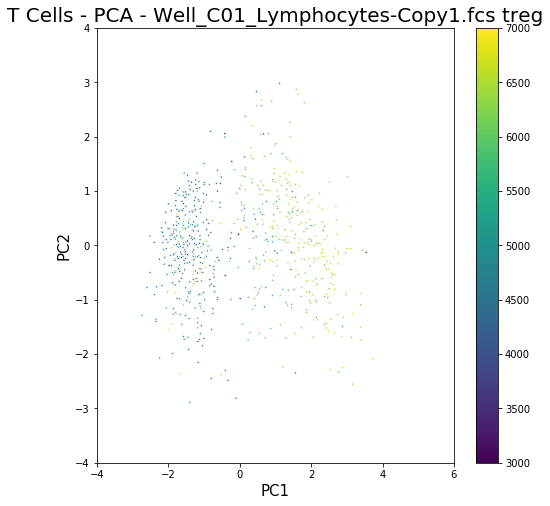

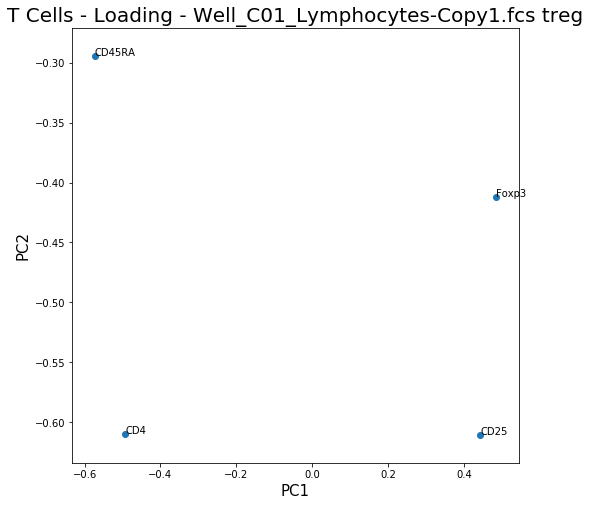

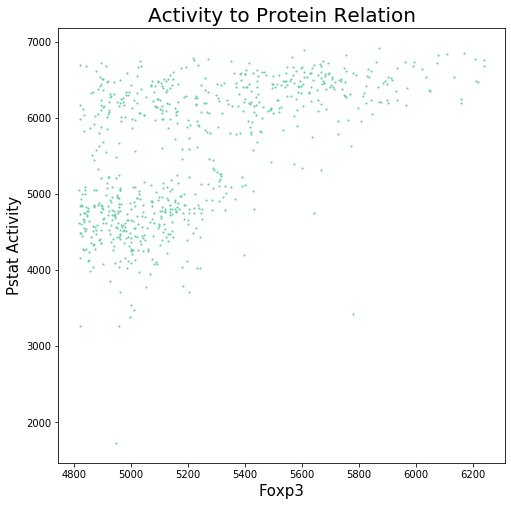

mean pStat activity:  5626.501


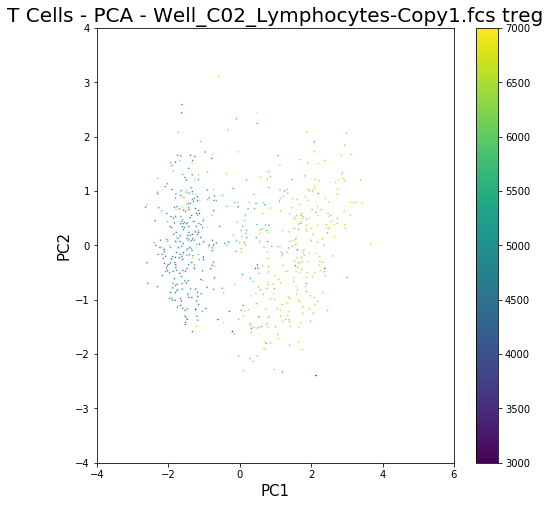

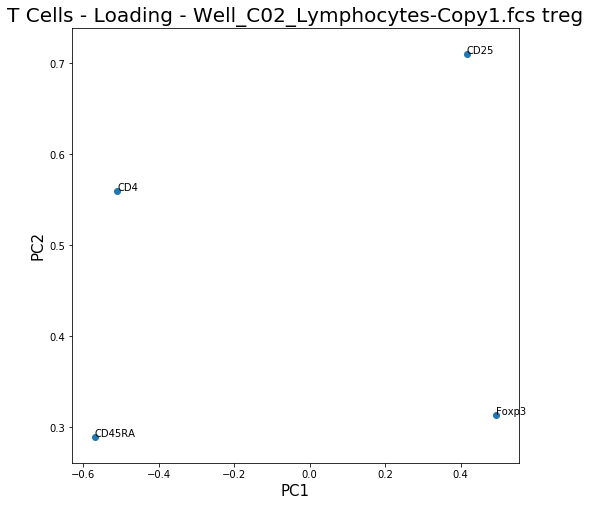

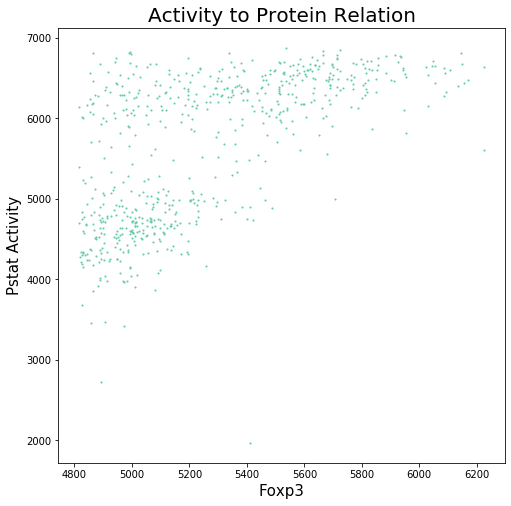

mean pStat activity:  5497.1445


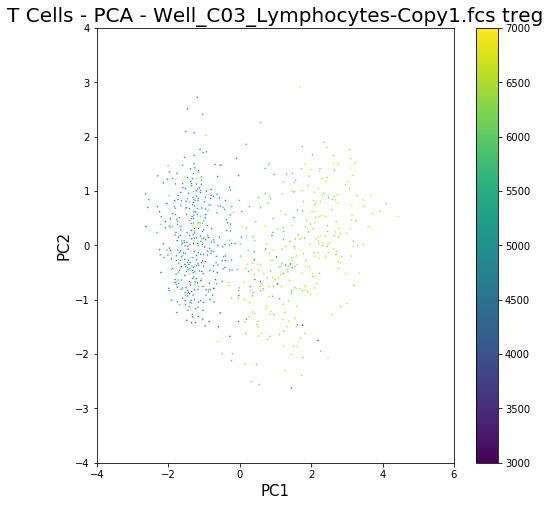

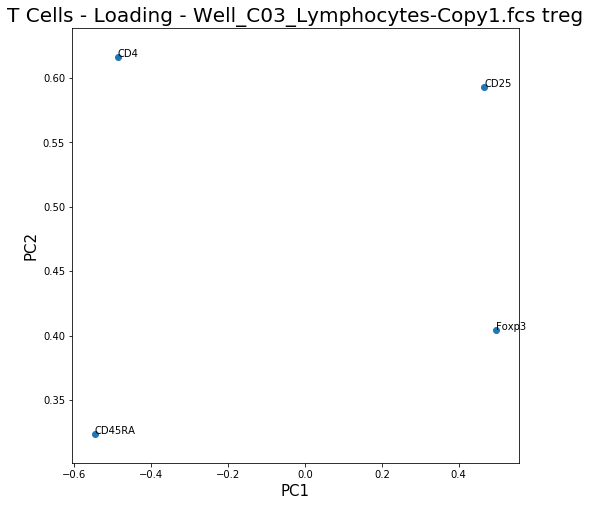

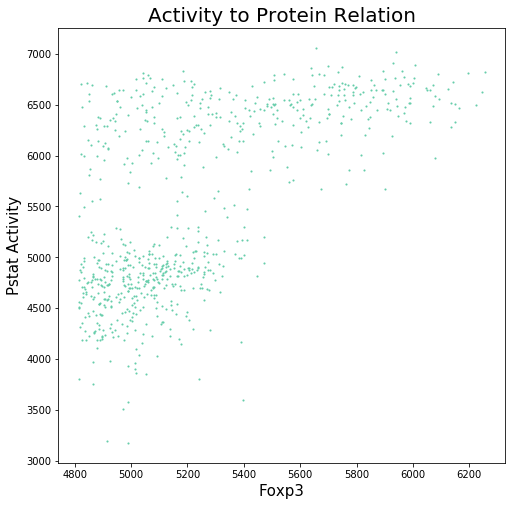

mean pStat activity:  5573.607


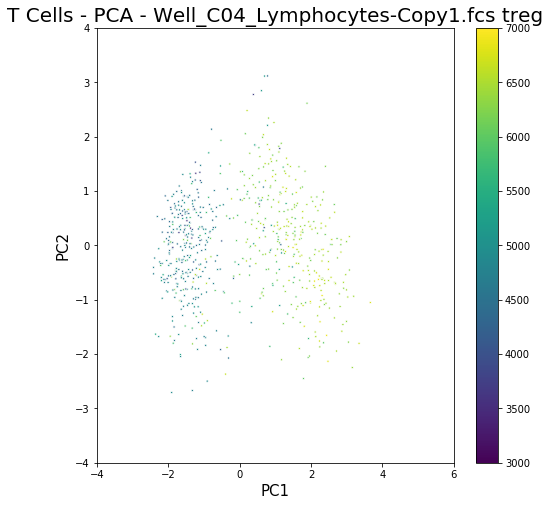

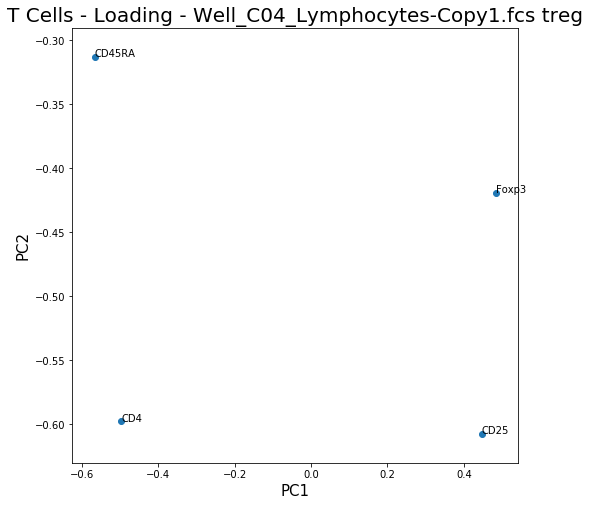

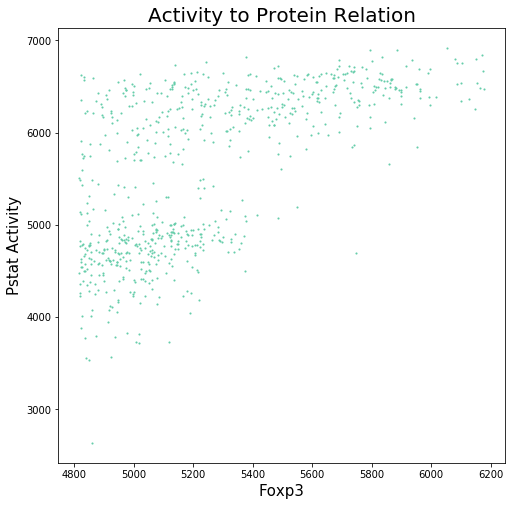

mean pStat activity:  5458.4805


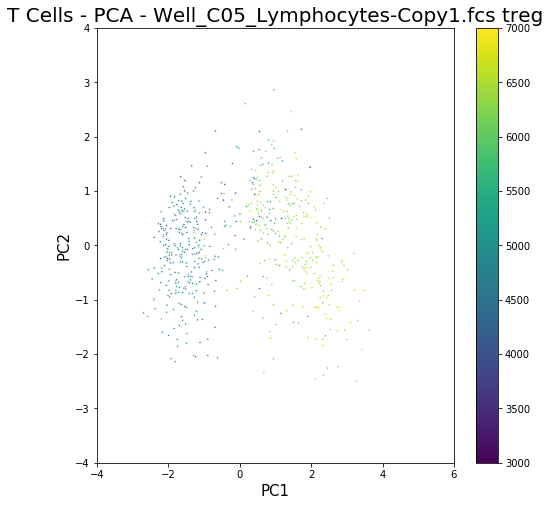

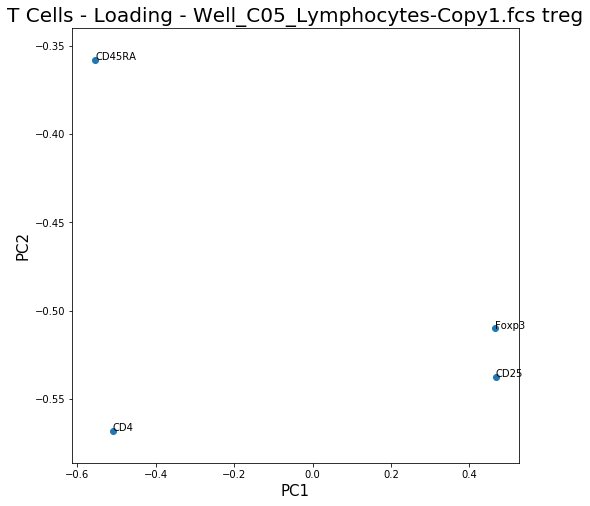

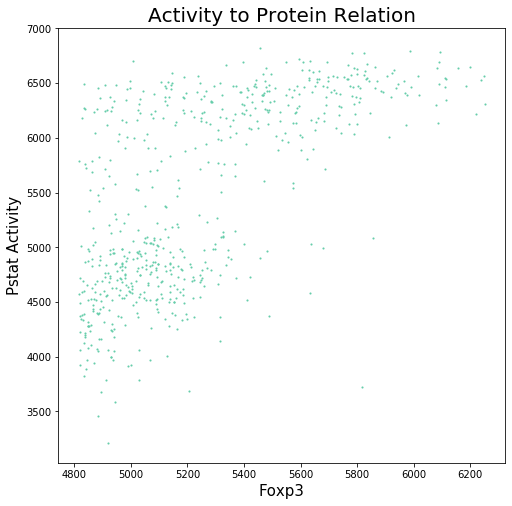

mean pStat activity:  5239.2305


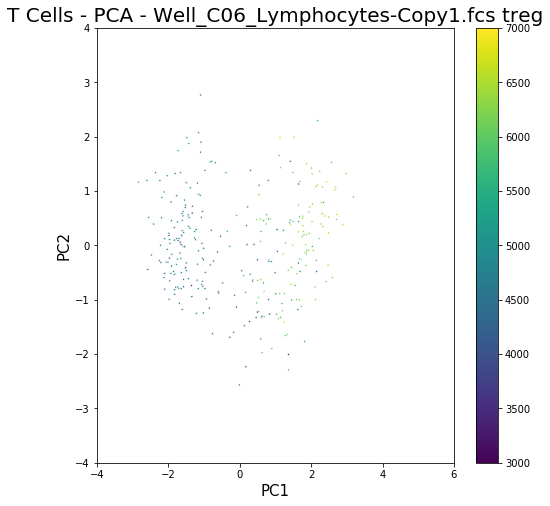

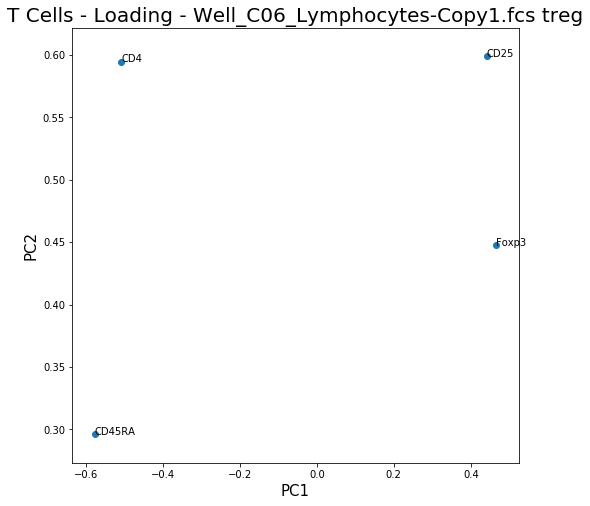

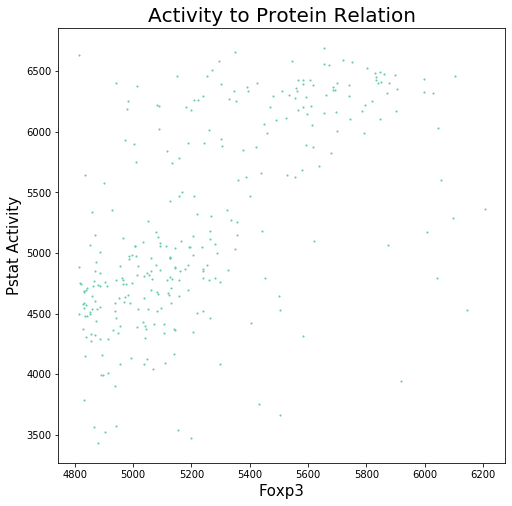

mean pStat activity:  4952.7217


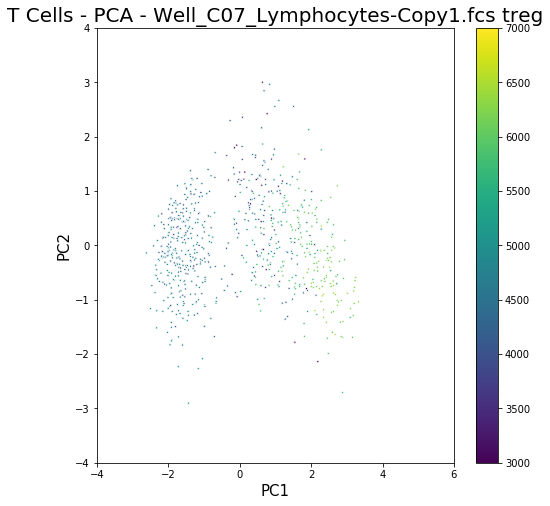

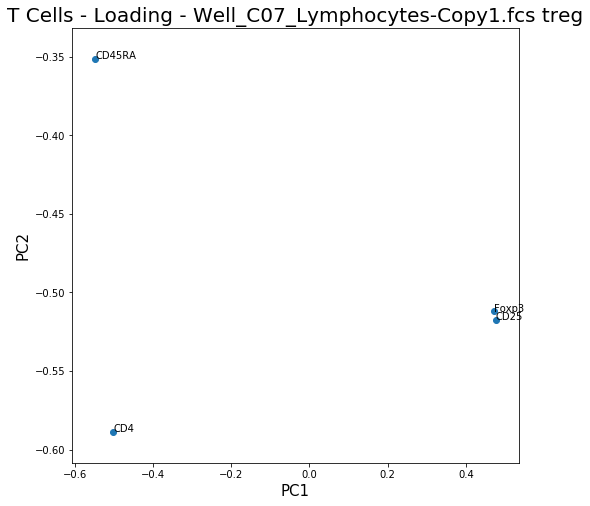

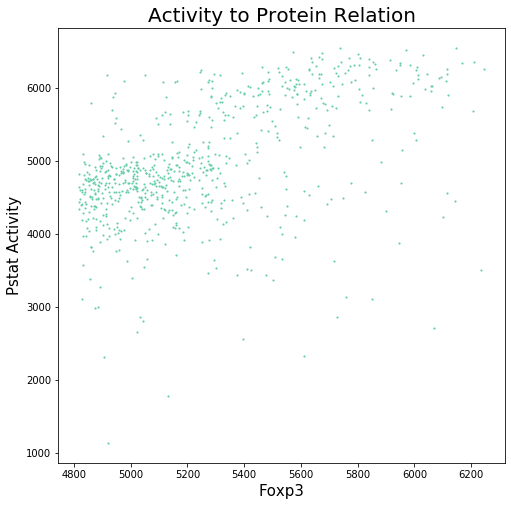

mean pStat activity:  4643.4893


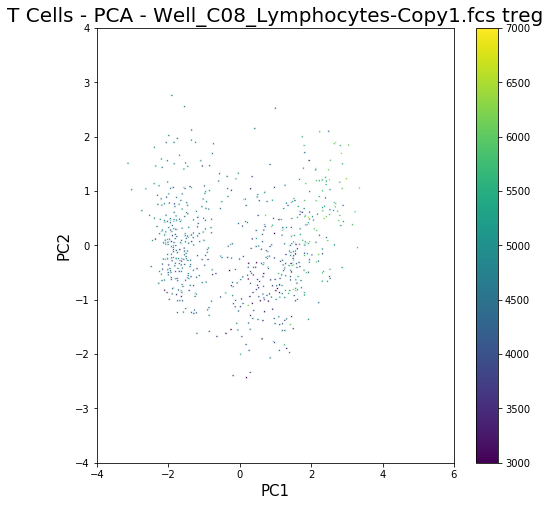

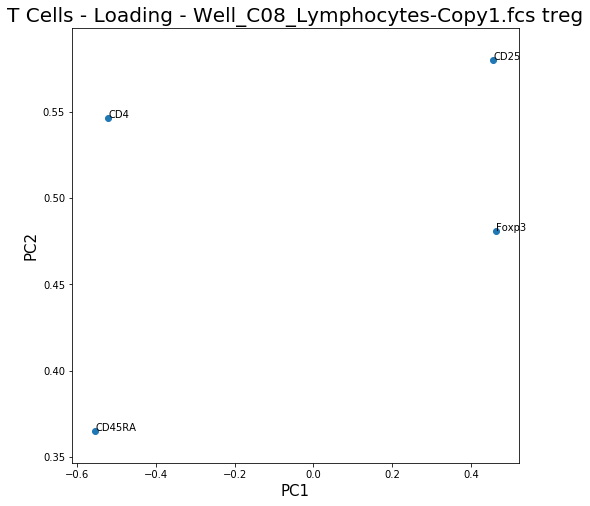

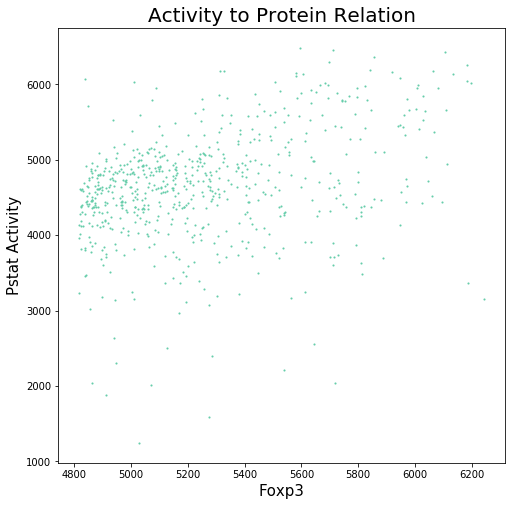

mean pStat activity:  4490.831


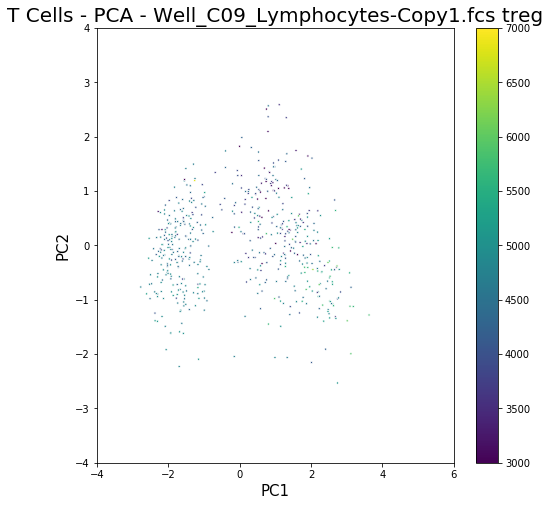

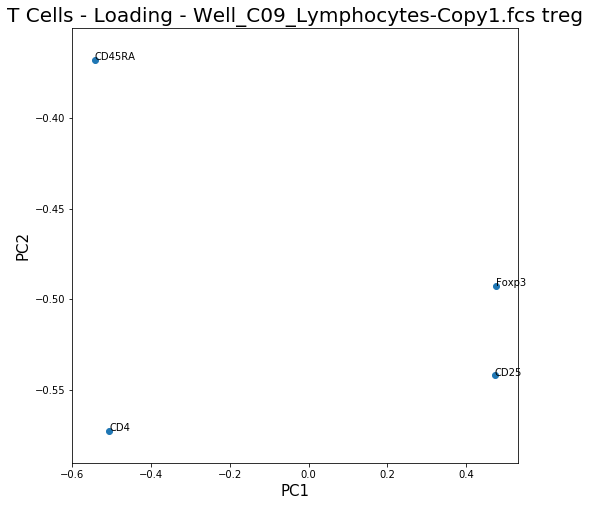

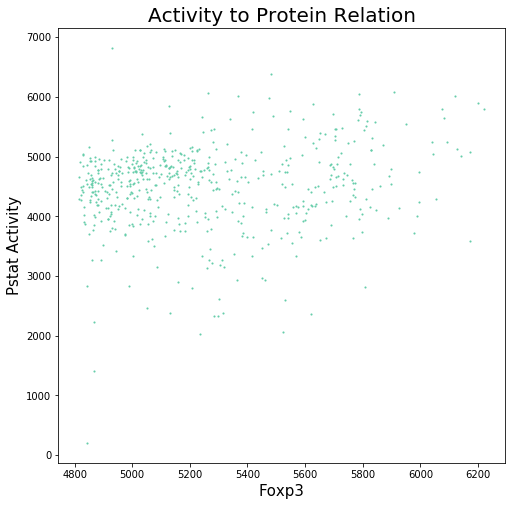

mean pStat activity:  4481.272


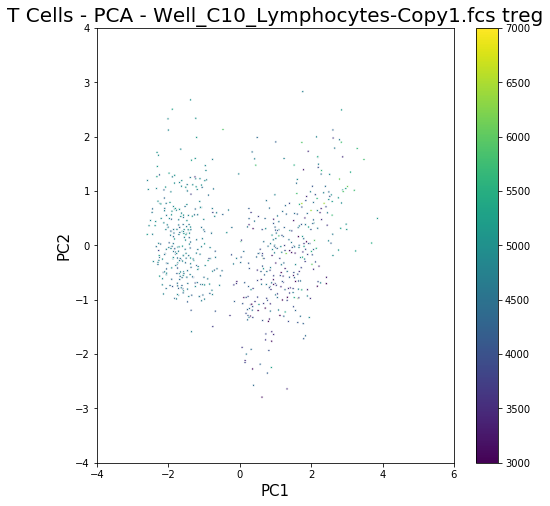

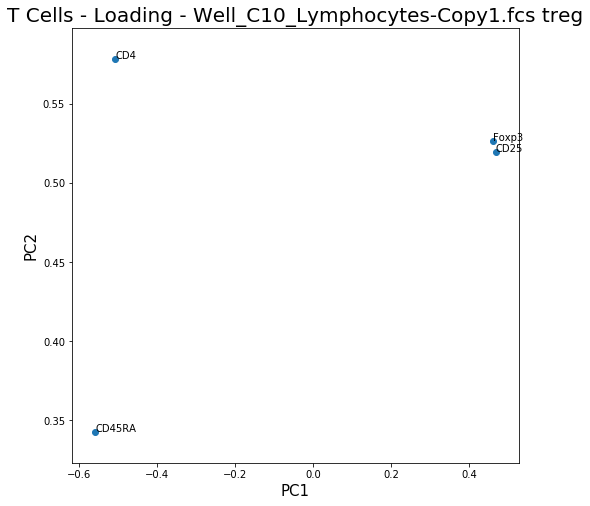

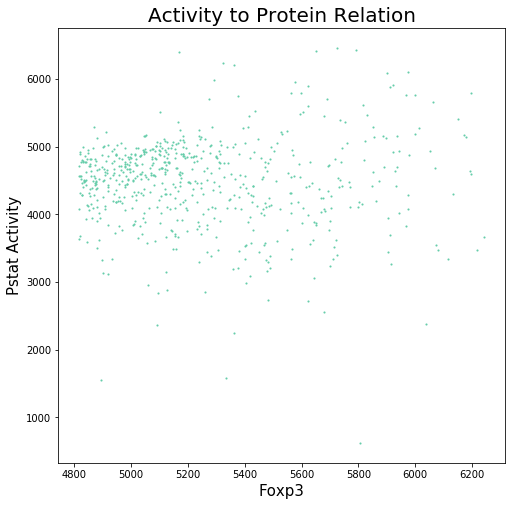

mean pStat activity:  4312.757


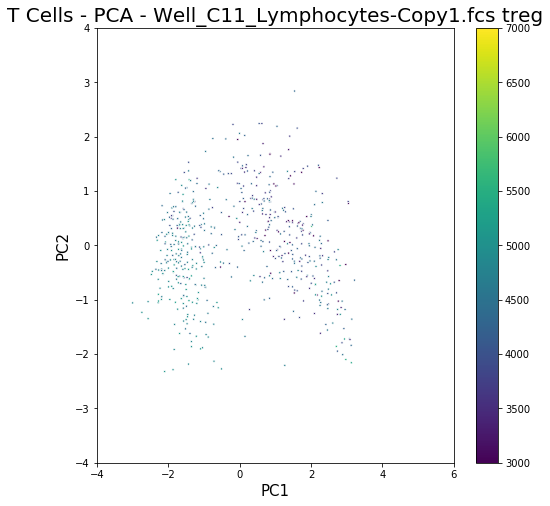

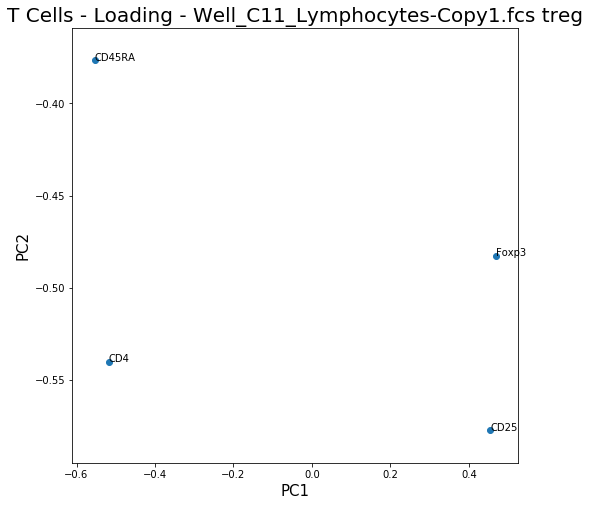

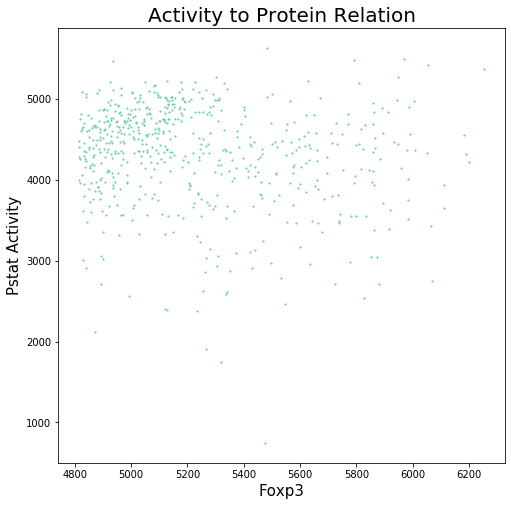

mean pStat activity:  4351.451


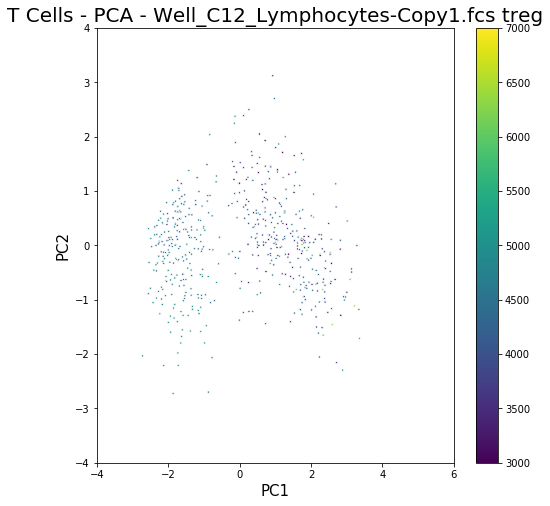

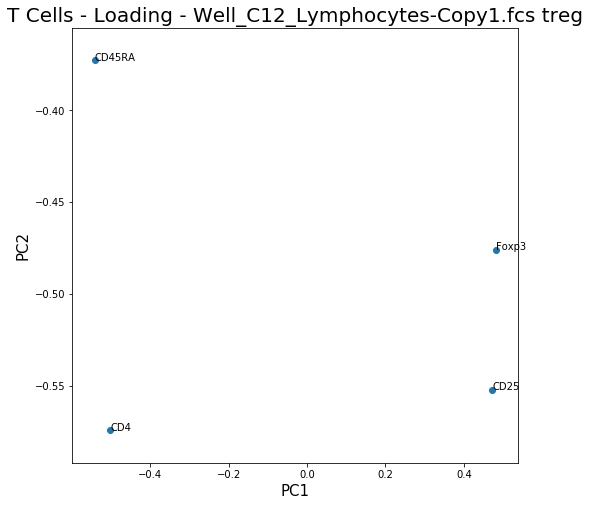

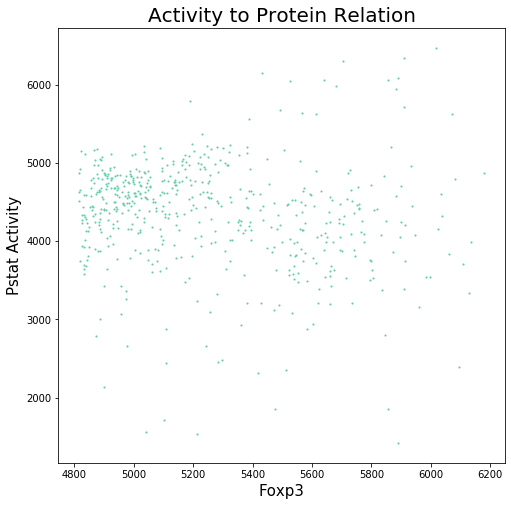

mean pStat activity:  5322.25


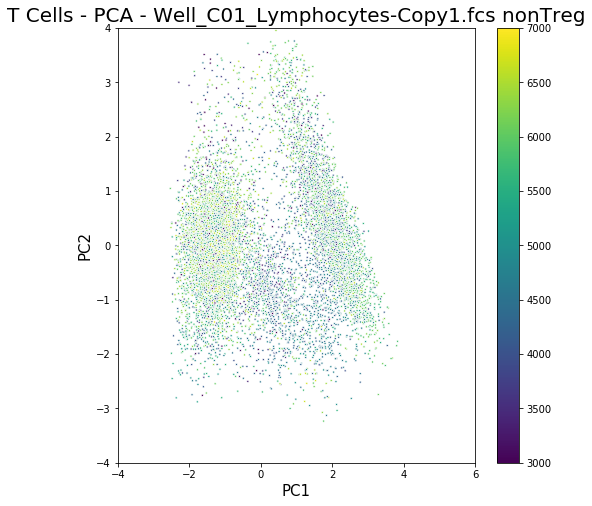

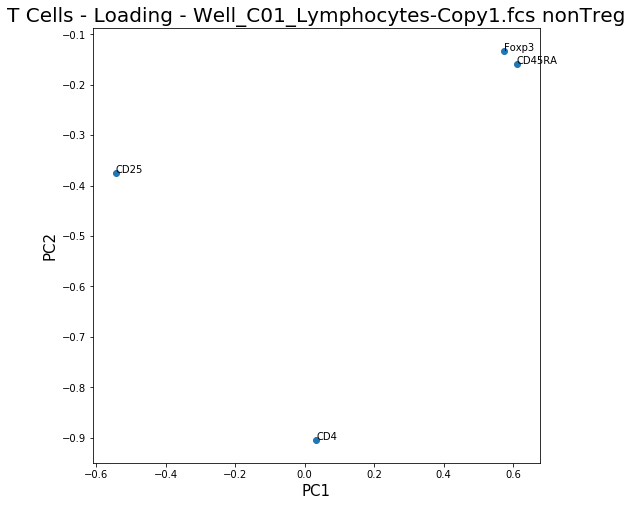

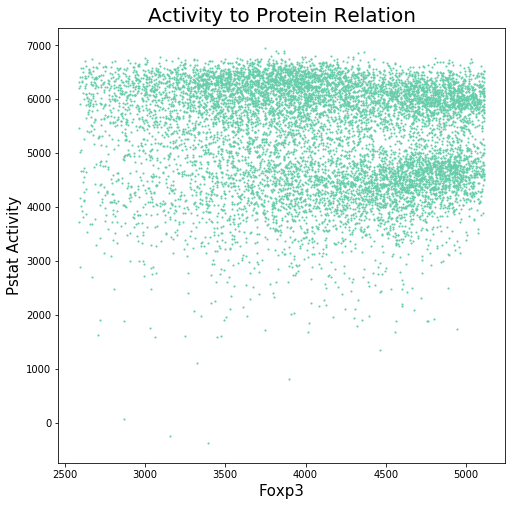

mean pStat activity:  5336.9985


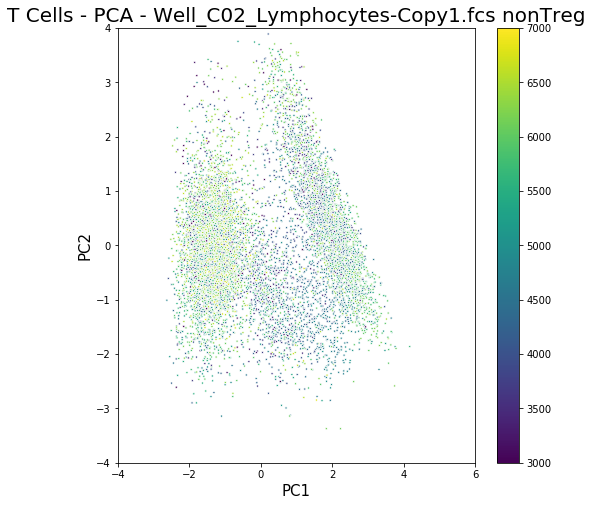

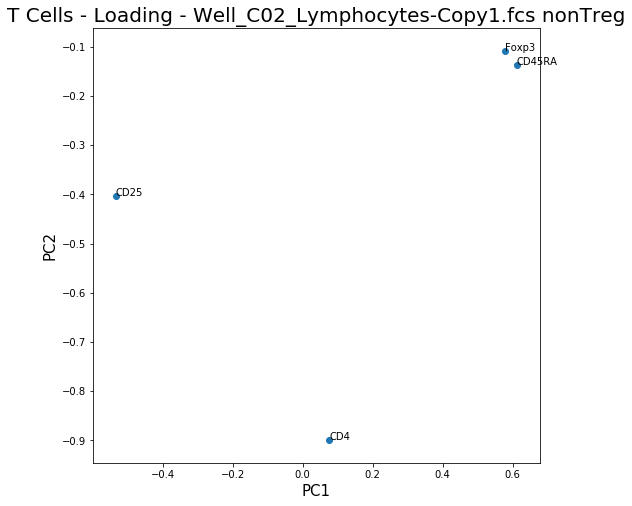

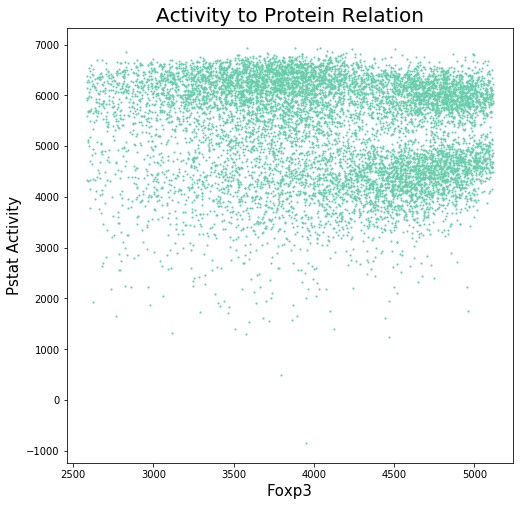

mean pStat activity:  5435.3354


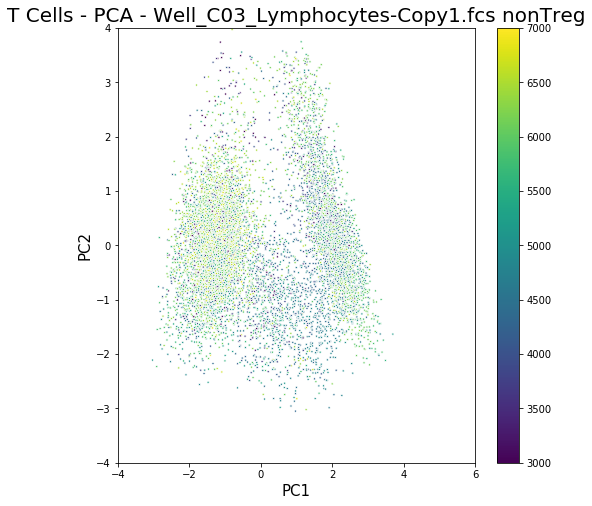

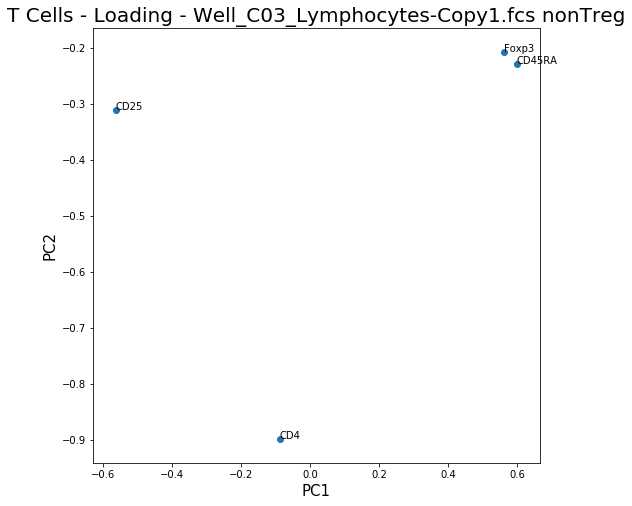

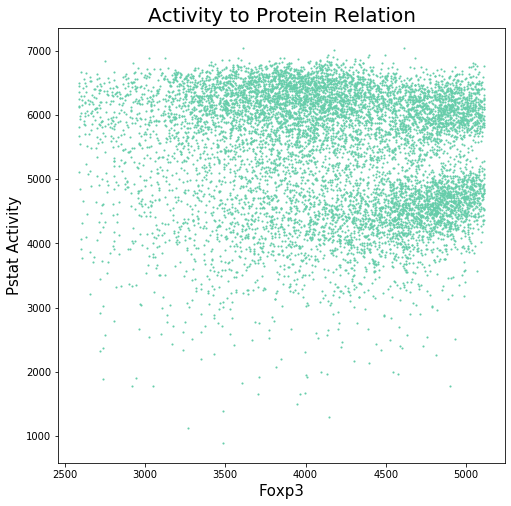

mean pStat activity:  5235.6226


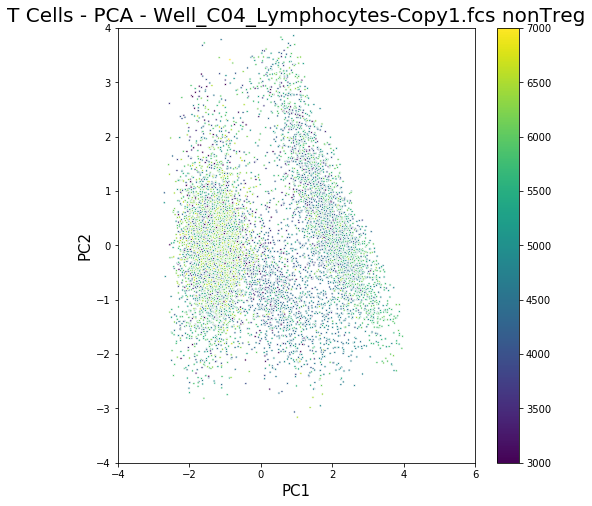

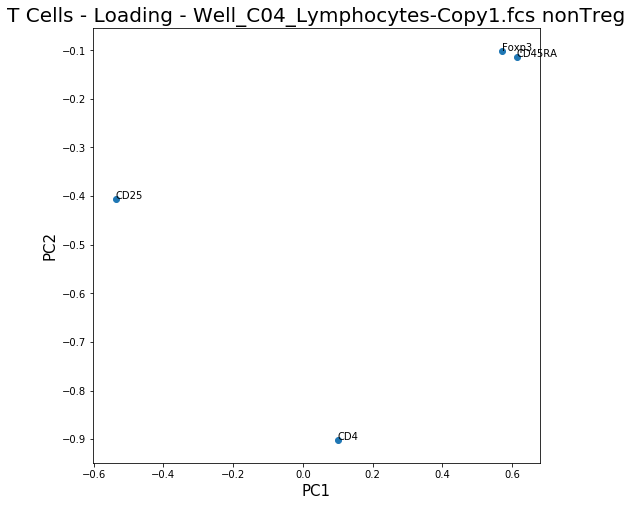

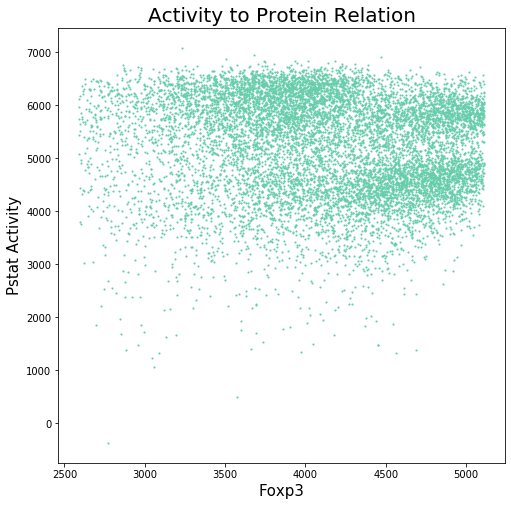

mean pStat activity:  4700.4937


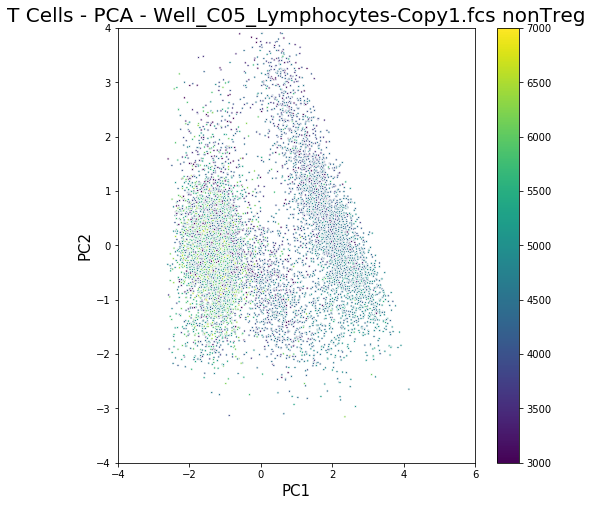

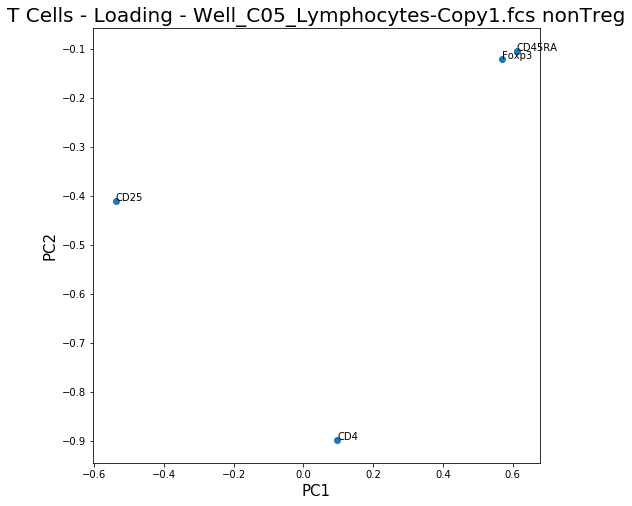

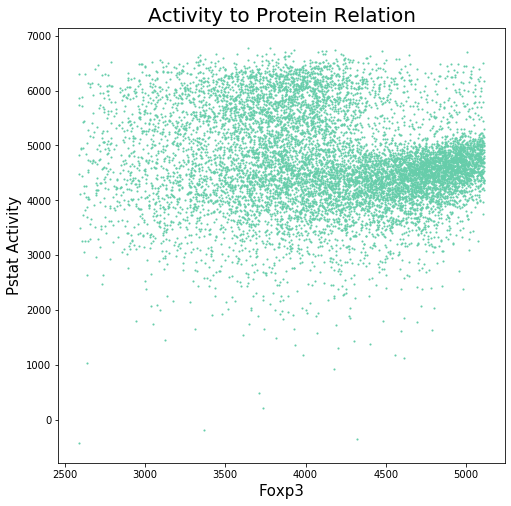

mean pStat activity:  4375.7446


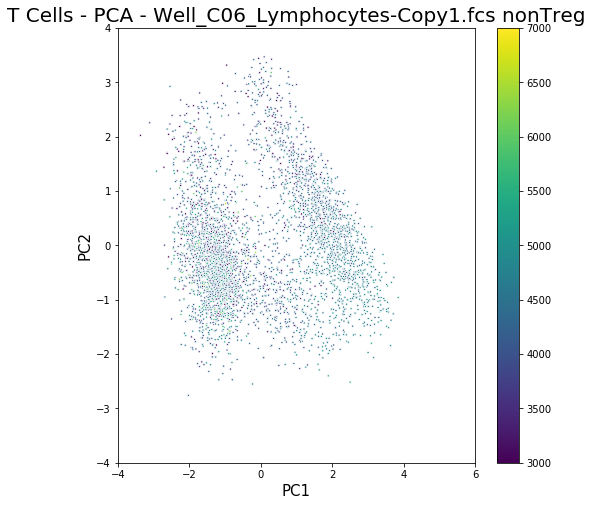

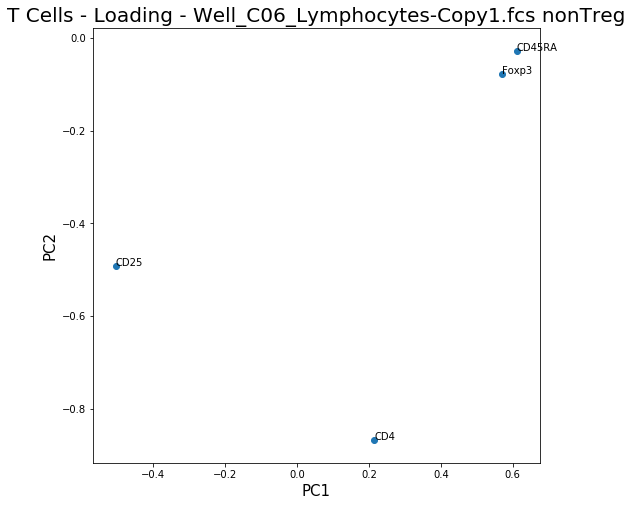

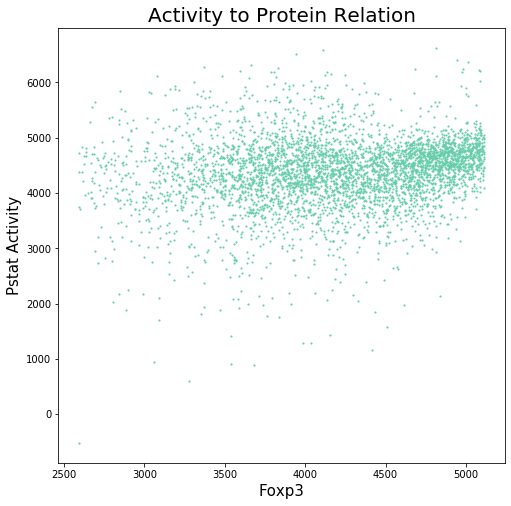

mean pStat activity:  4165.586


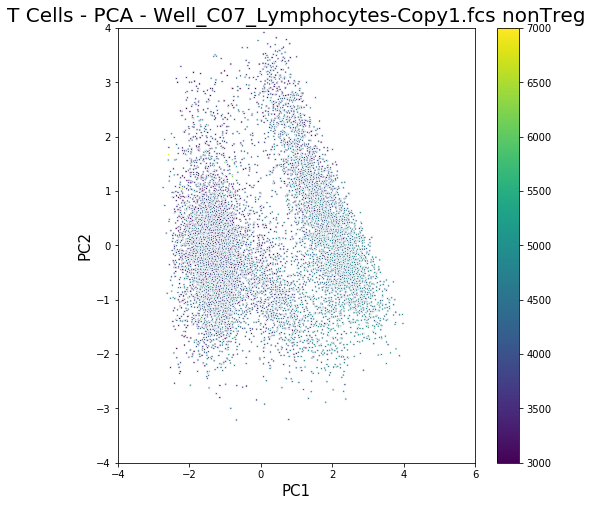

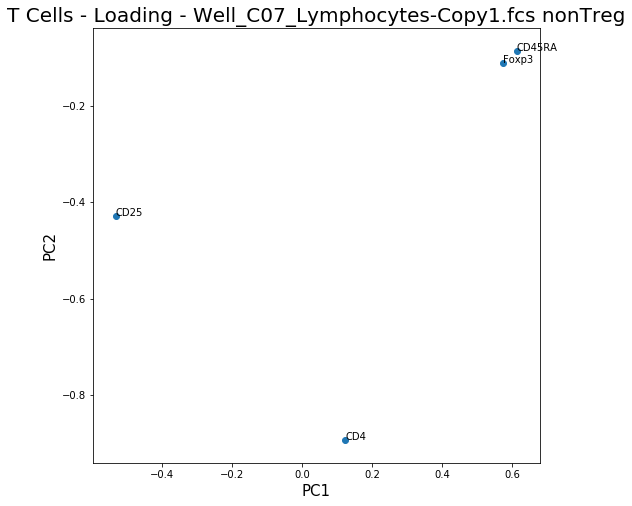

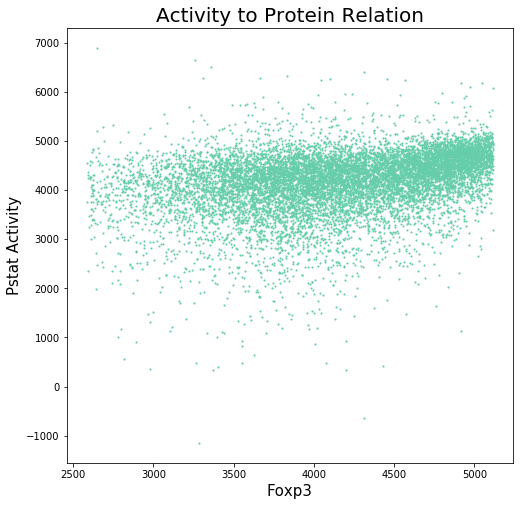

mean pStat activity:  4115.053


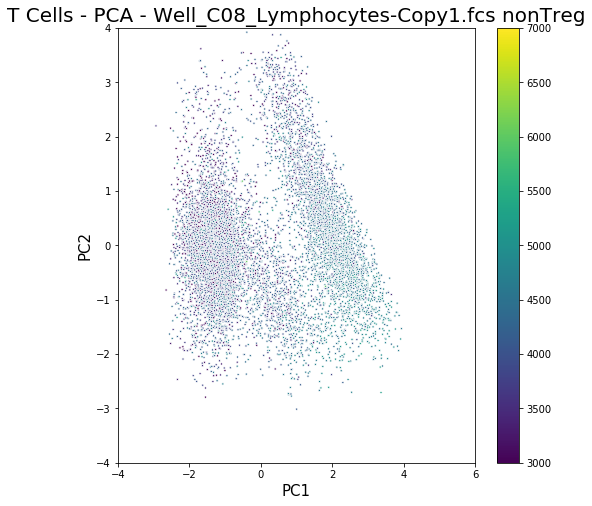

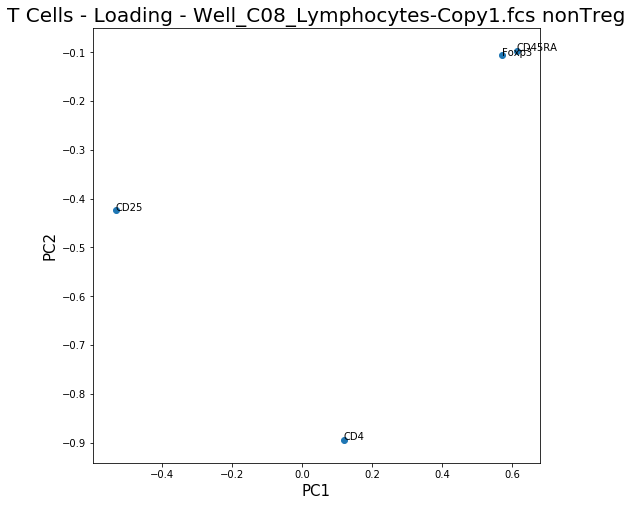

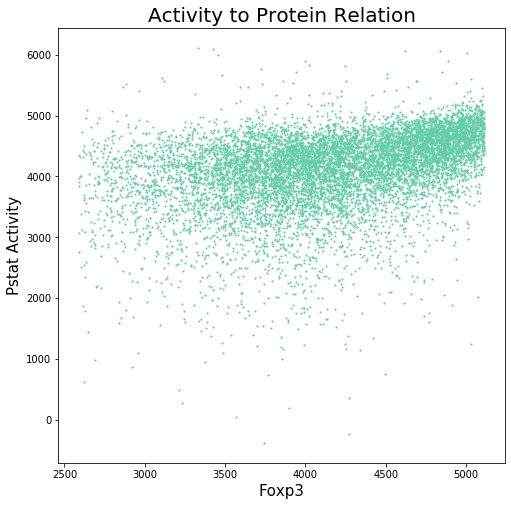

mean pStat activity:  4078.7979


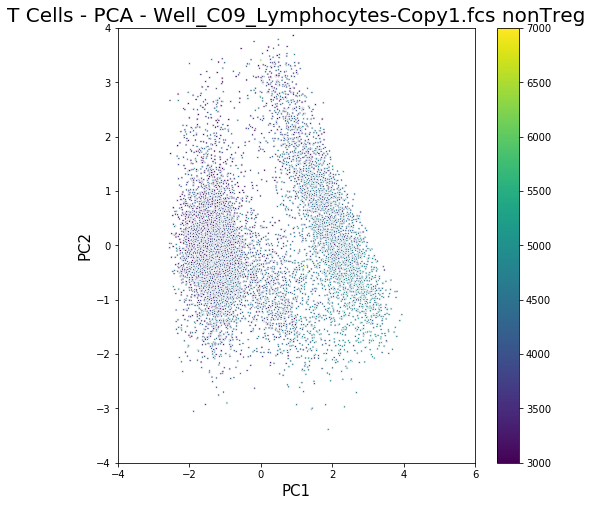

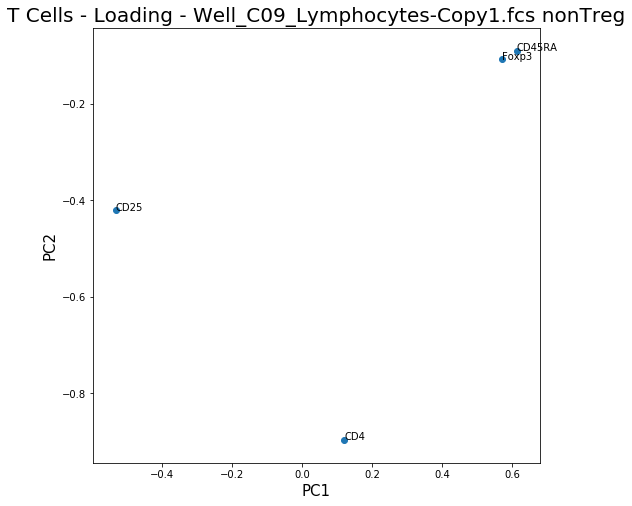

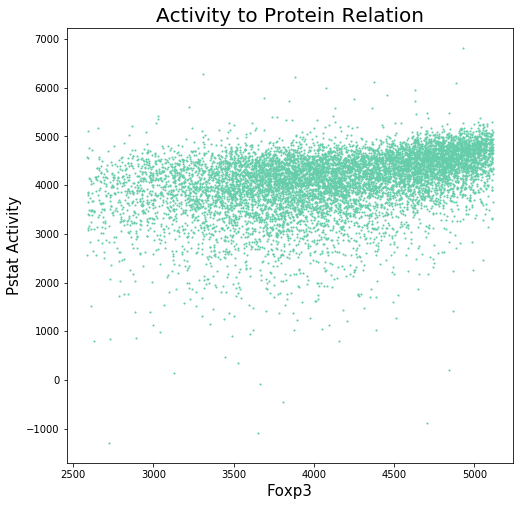

mean pStat activity:  4113.188


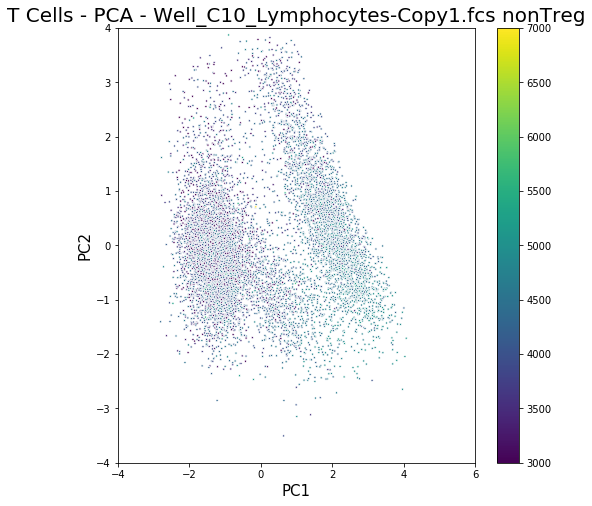

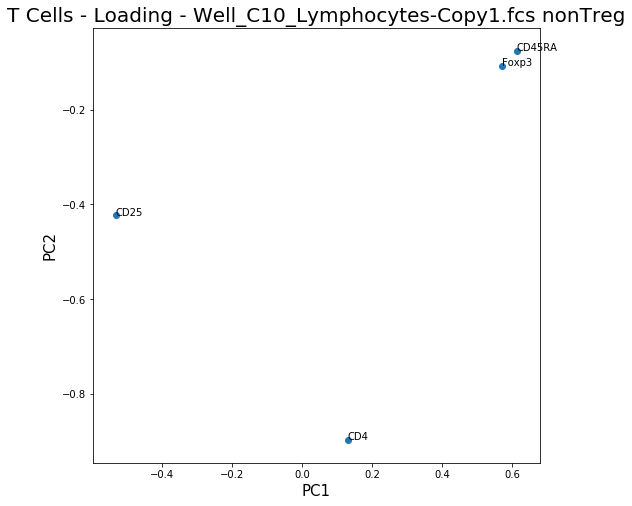

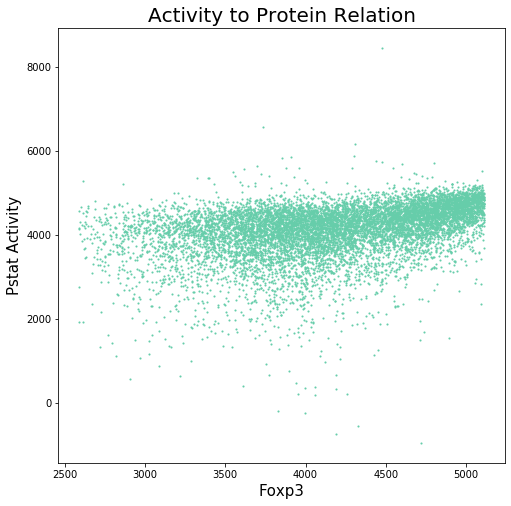

mean pStat activity:  4099.097


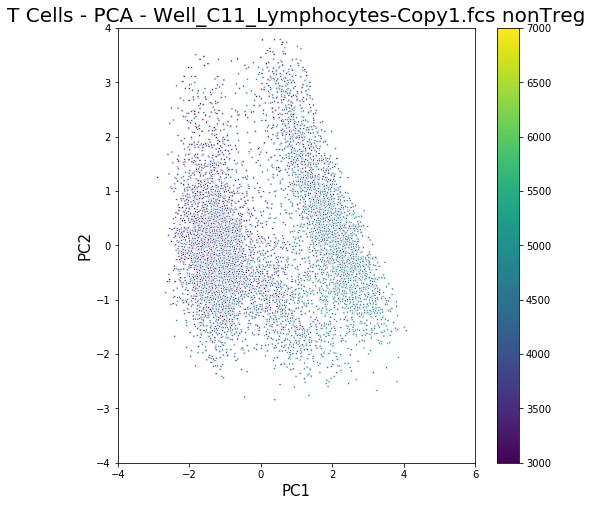

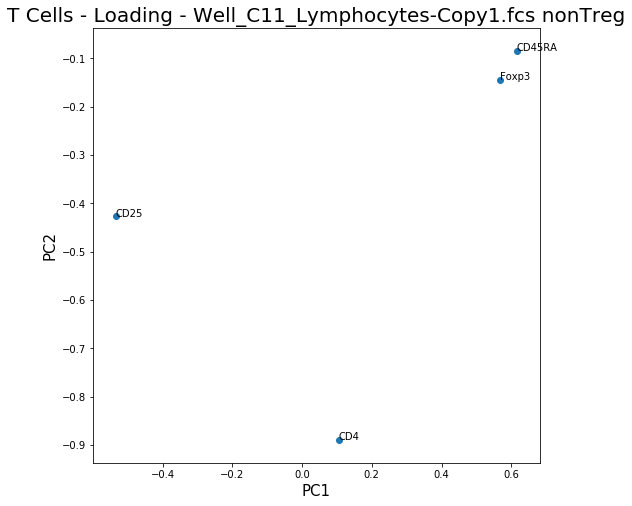

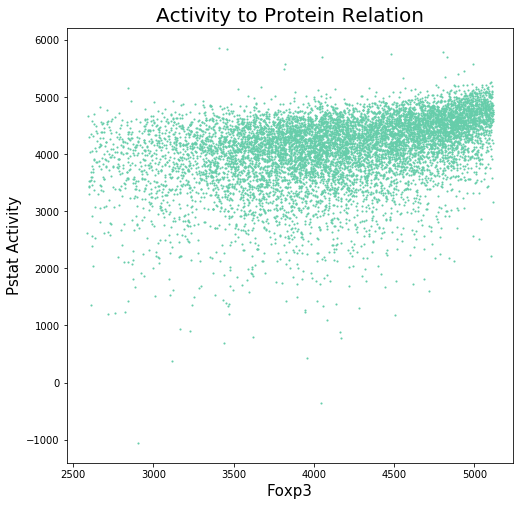

mean pStat activity:  4114.7334


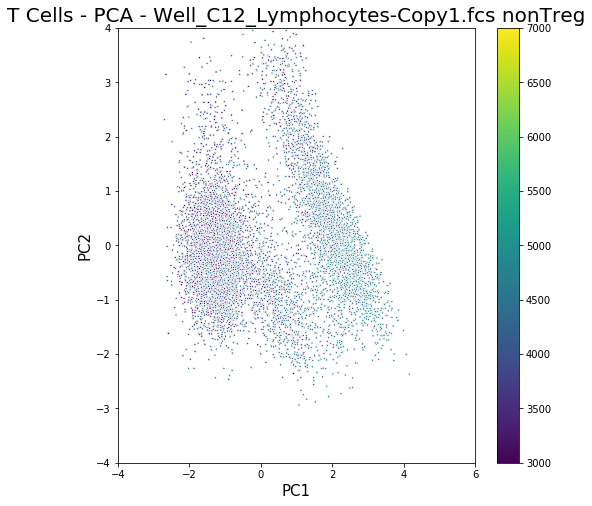

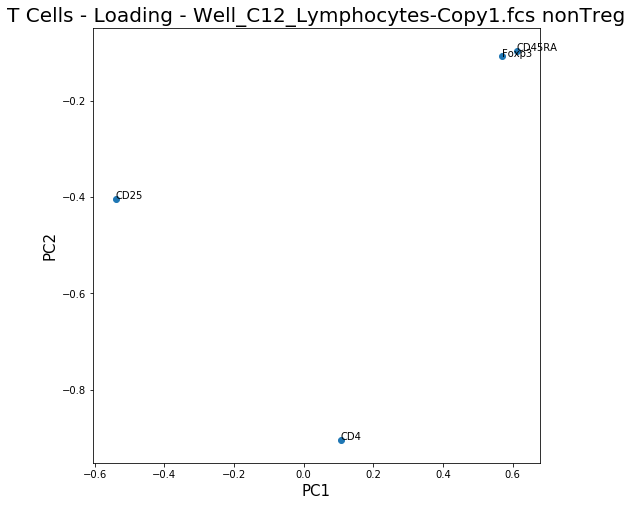

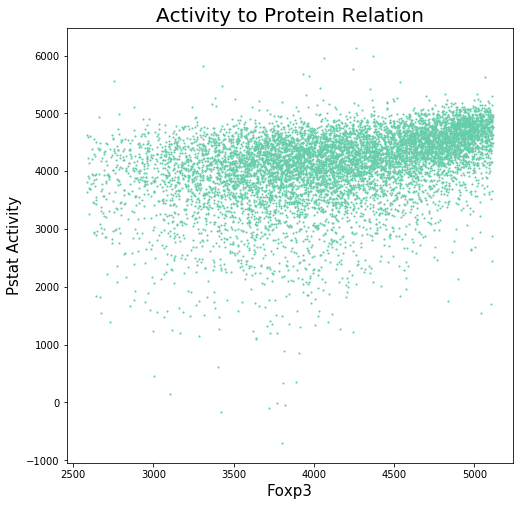

mean pStat activity:  6321.1167


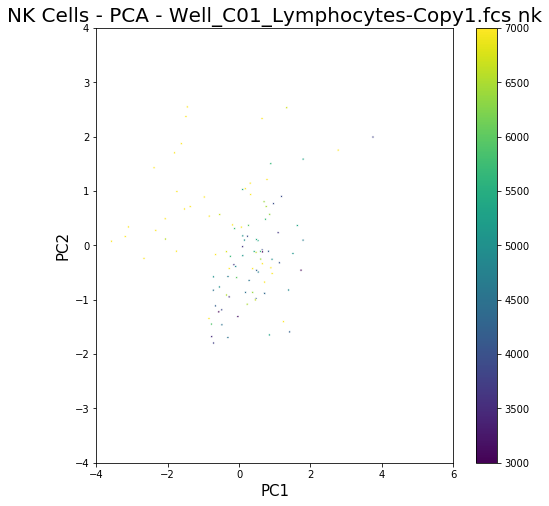

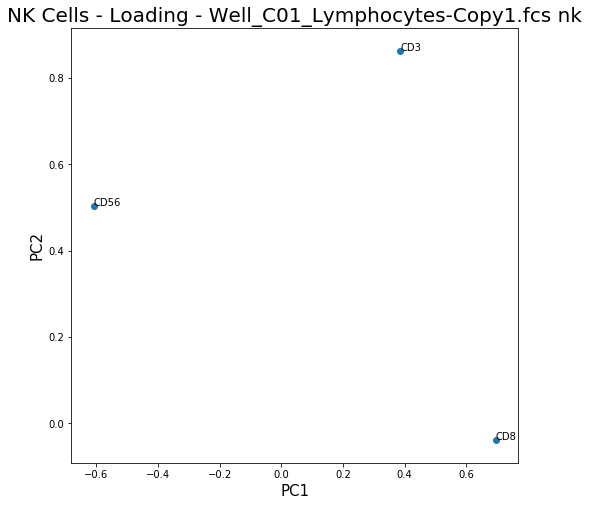

mean pStat activity:  6616.5586


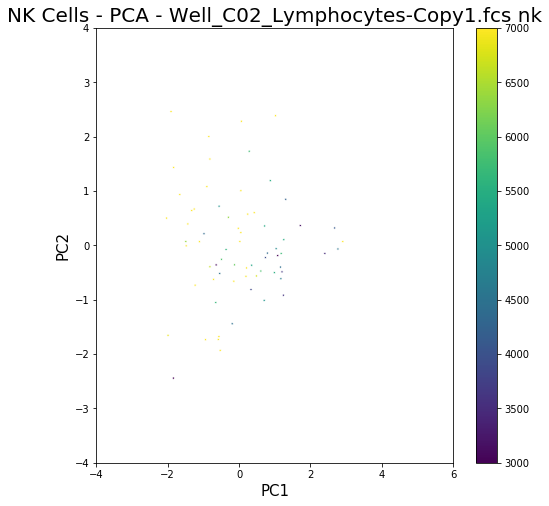

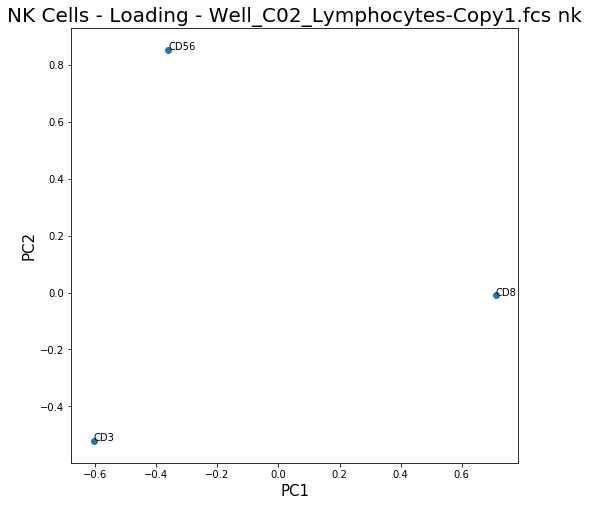

mean pStat activity:  6276.7744


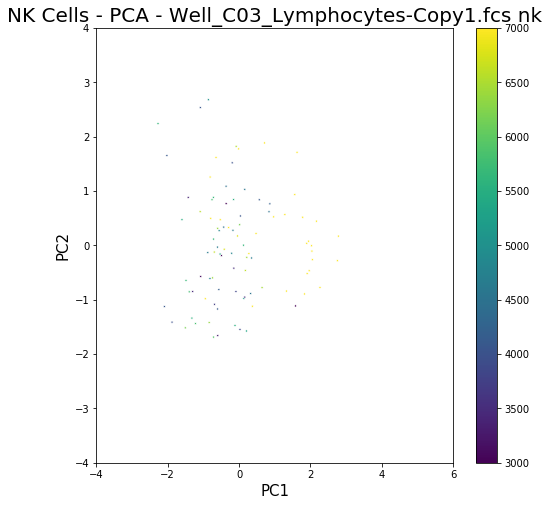

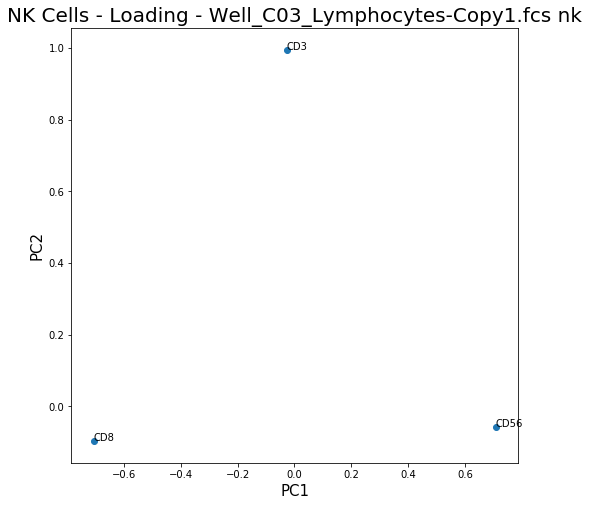

mean pStat activity:  5974.5947


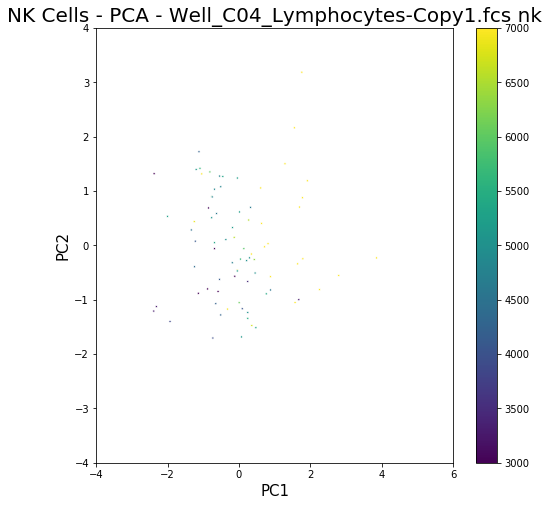

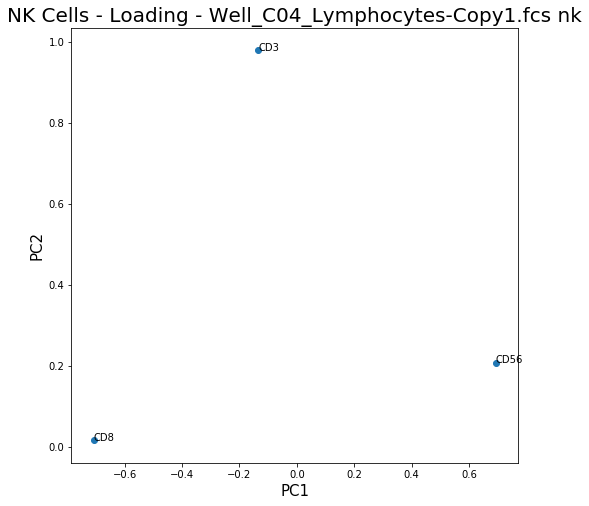

mean pStat activity:  4137.875


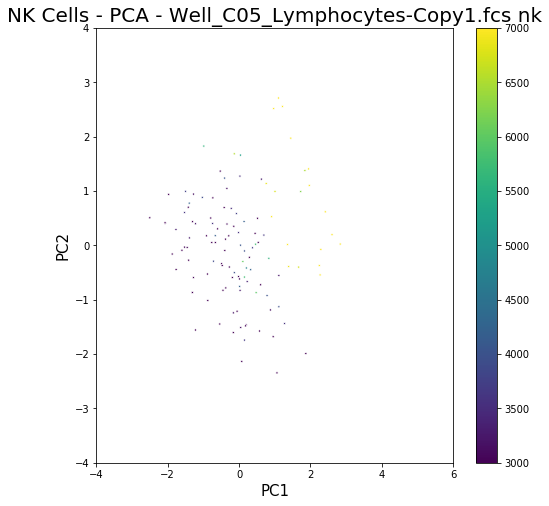

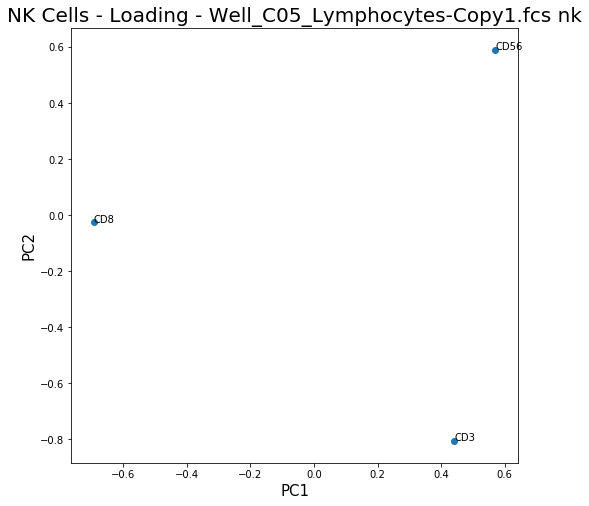

mean pStat activity:  3690.1082


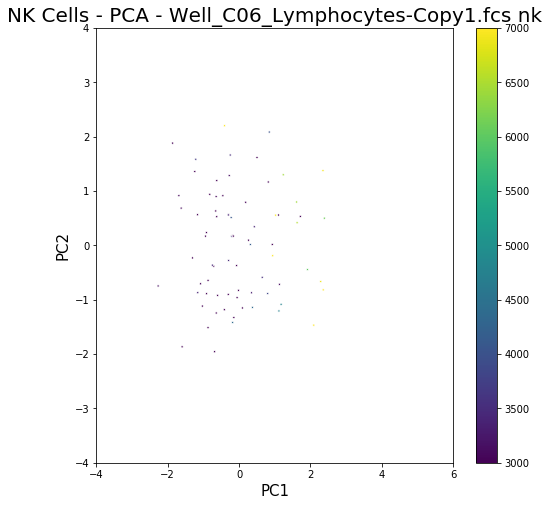

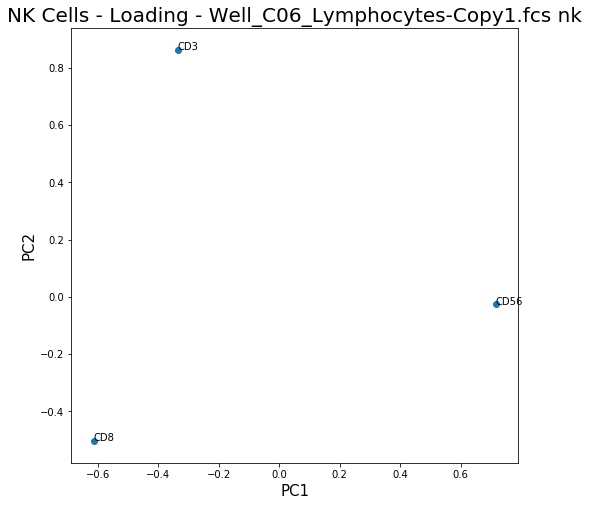

mean pStat activity:  3854.3333


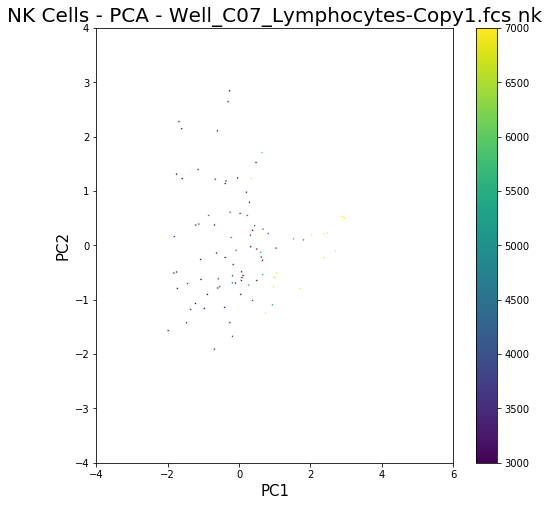

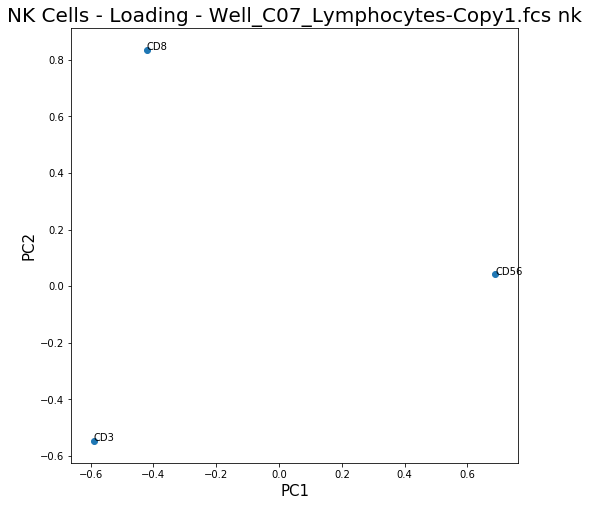

mean pStat activity:  3841.8572


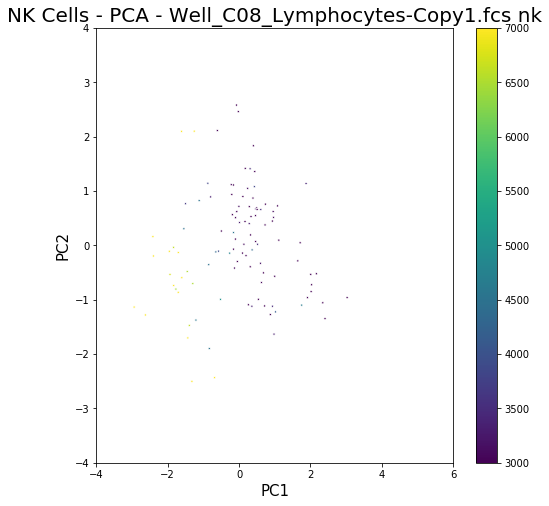

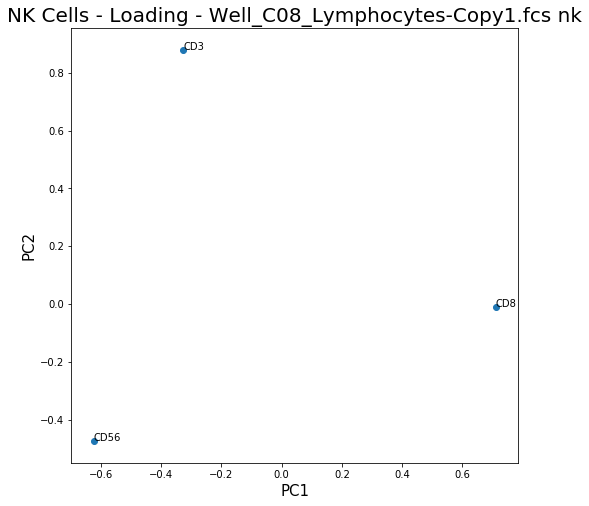

mean pStat activity:  3602.6826


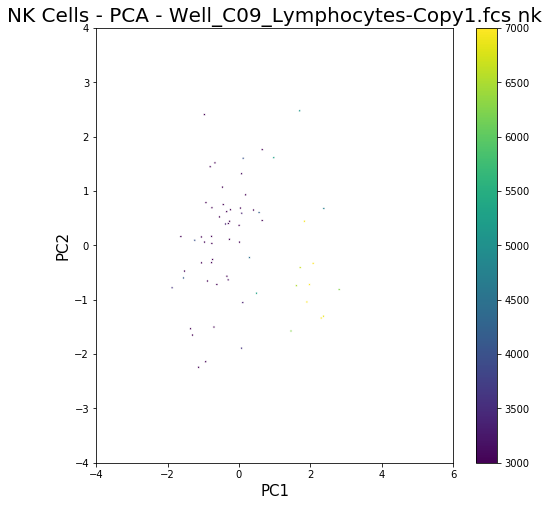

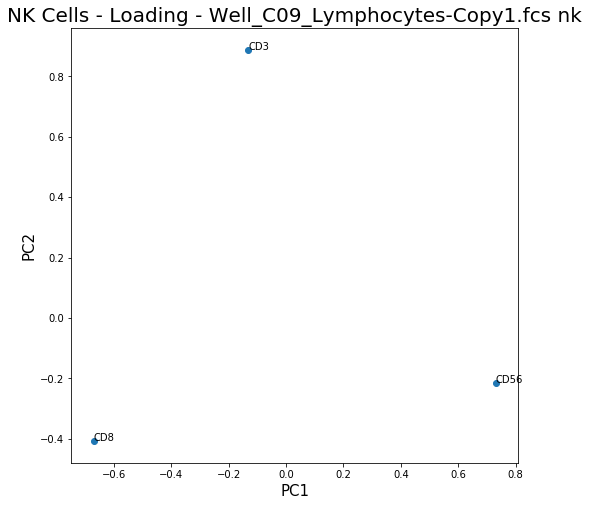

mean pStat activity:  3821.0278


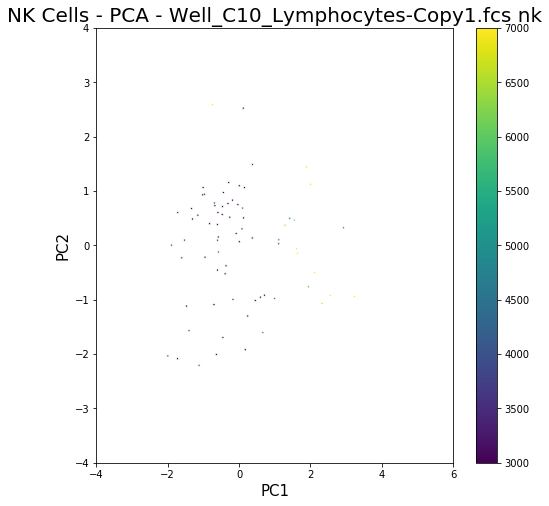

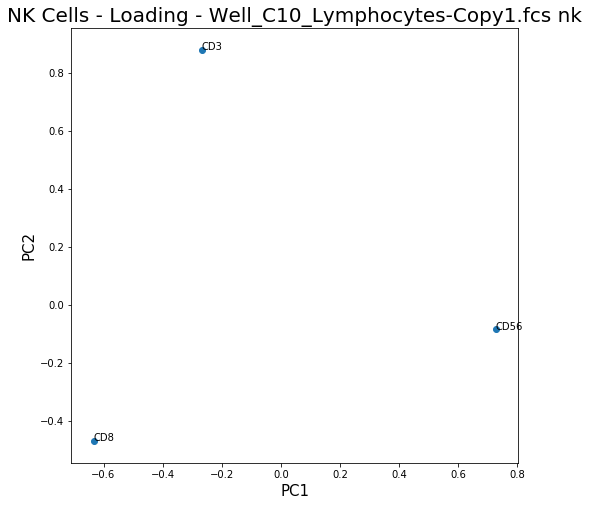

mean pStat activity:  3629.3333


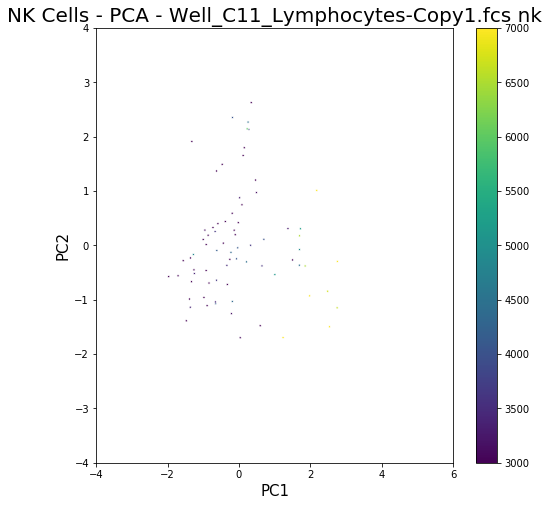

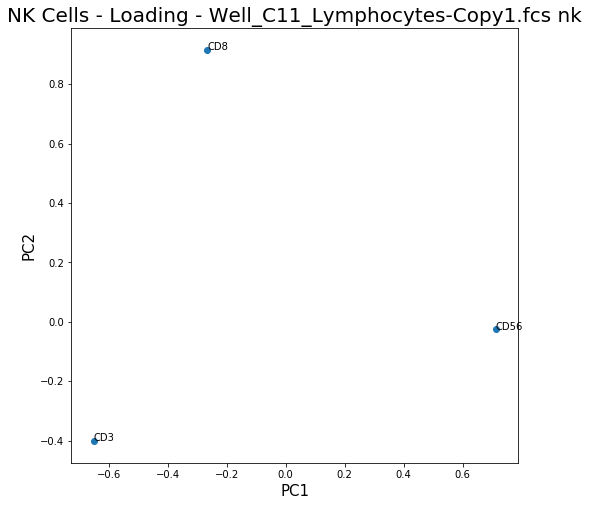

mean pStat activity:  4172.1763


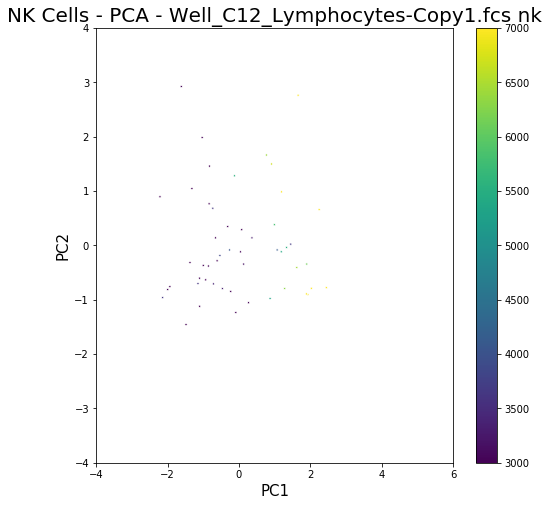

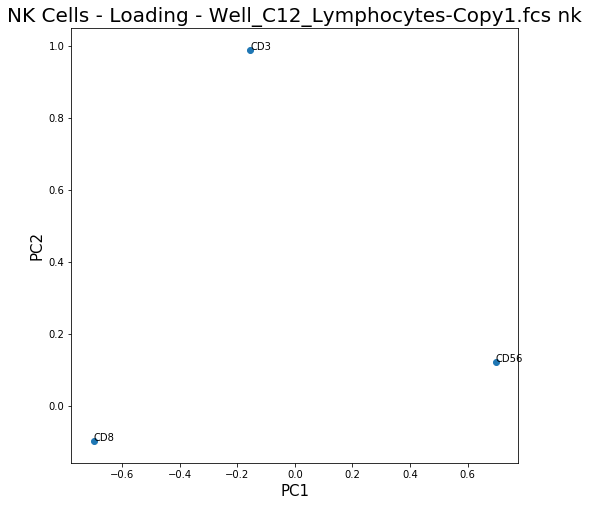

mean pStat activity:  17223.445


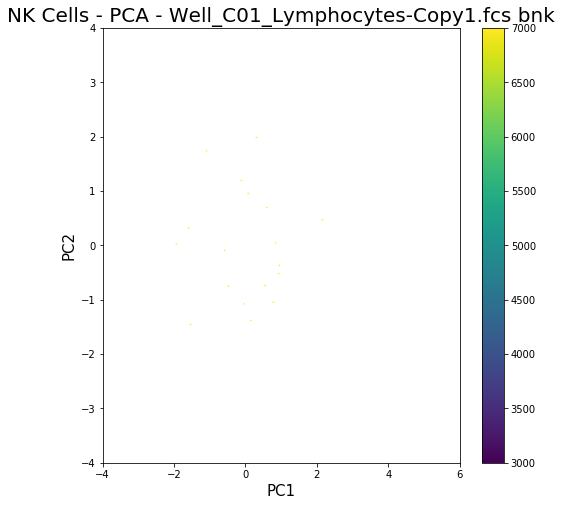

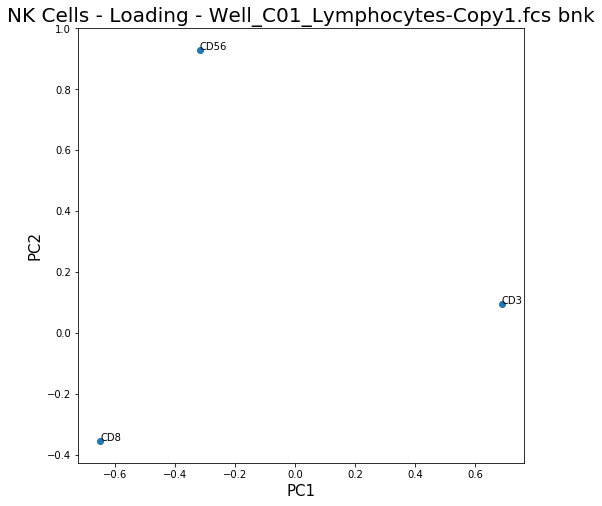

mean pStat activity:  17197.666


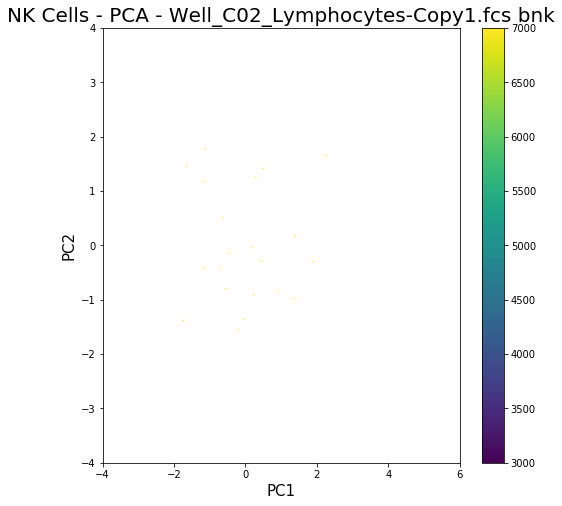

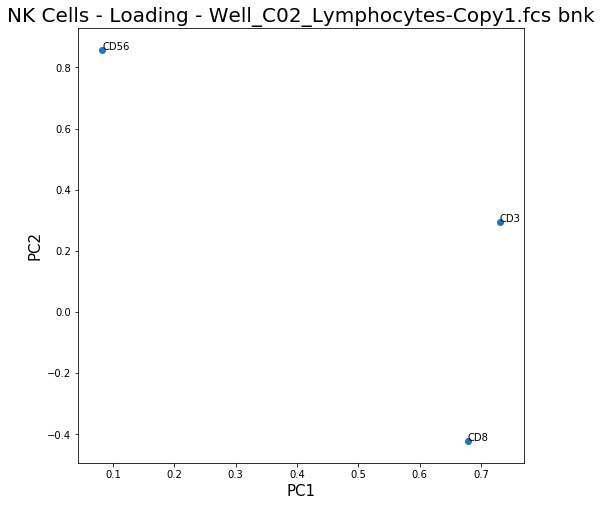

mean pStat activity:  16728.6


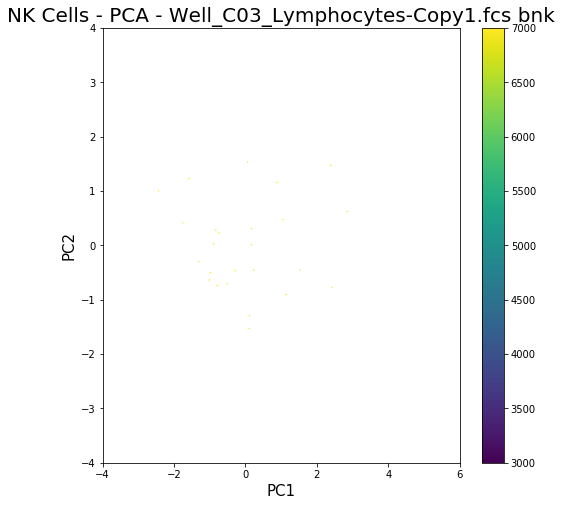

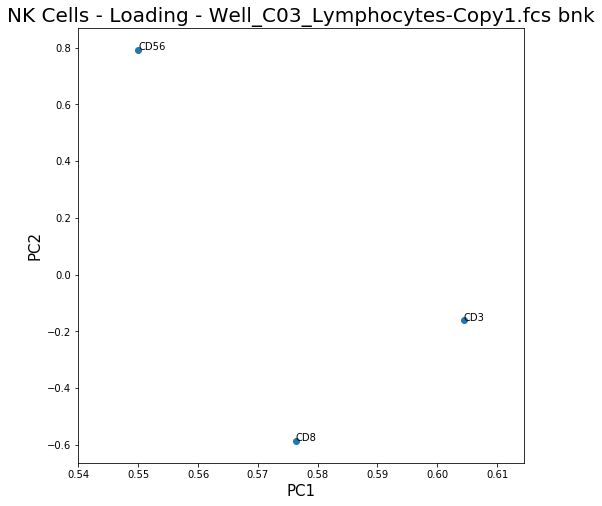

mean pStat activity:  16868.35


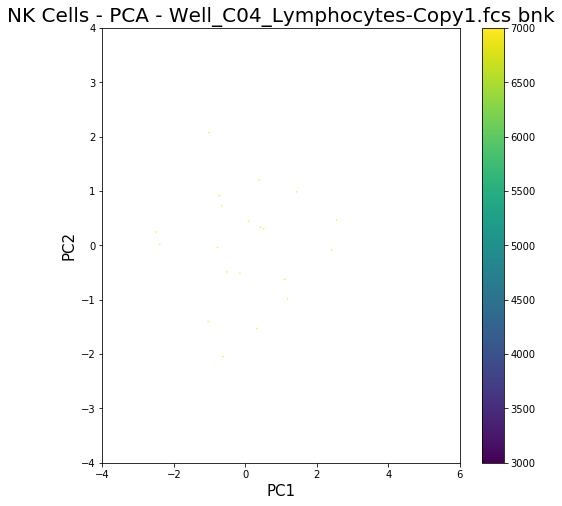

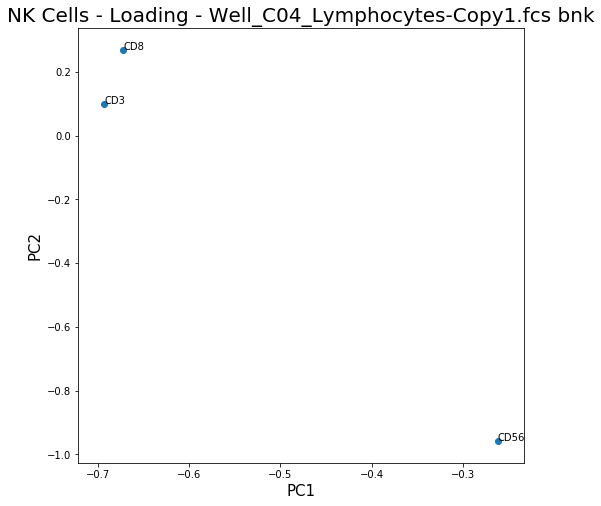

mean pStat activity:  15538.772


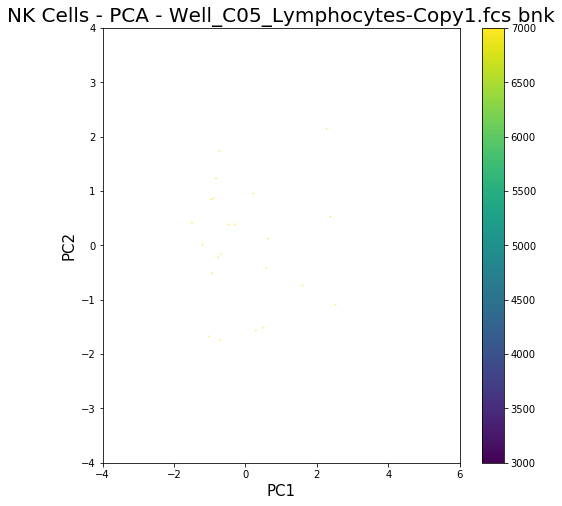

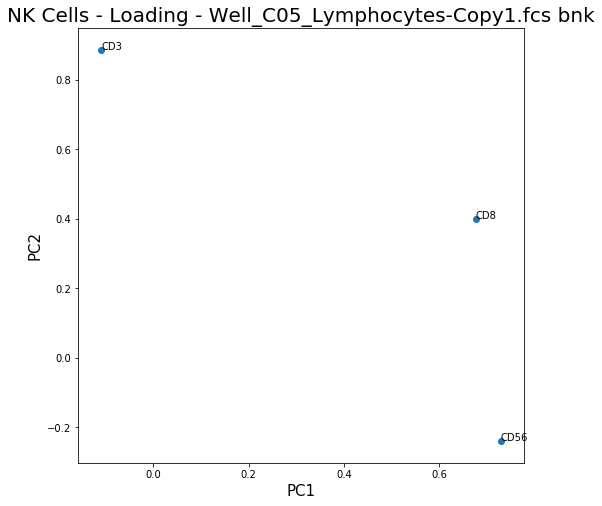

mean pStat activity:  13546.158


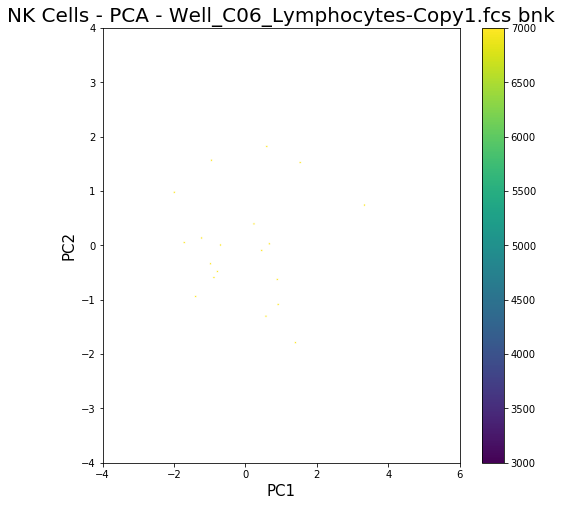

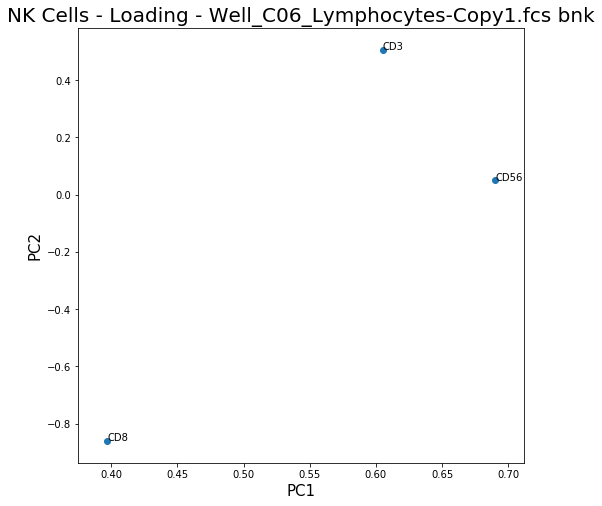

mean pStat activity:  11786.143


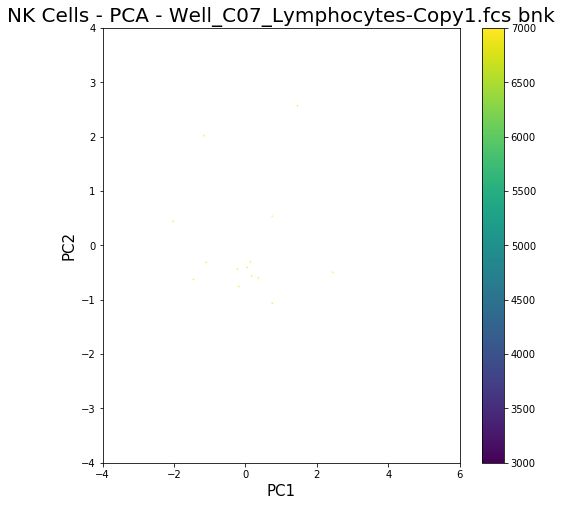

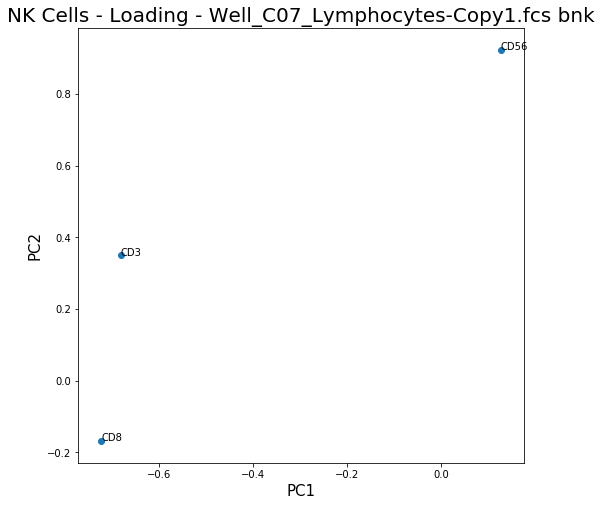

mean pStat activity:  13722.286


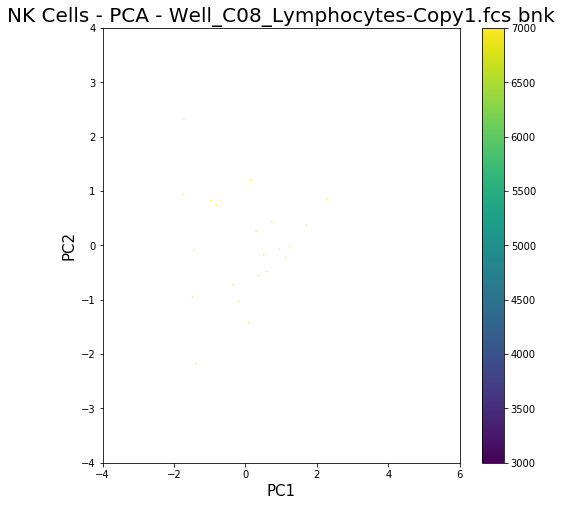

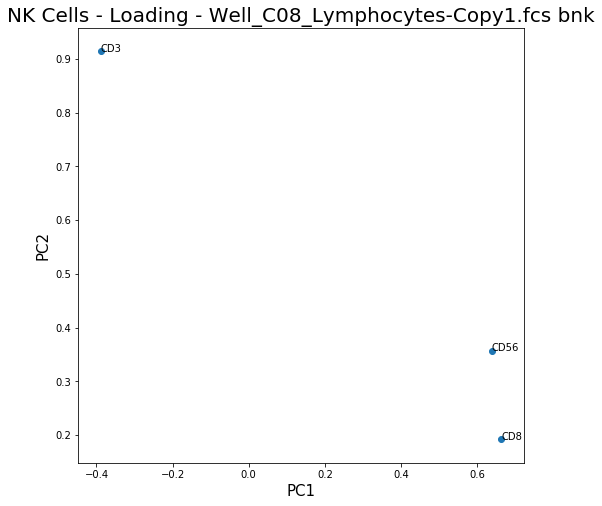

mean pStat activity:  11170.4375


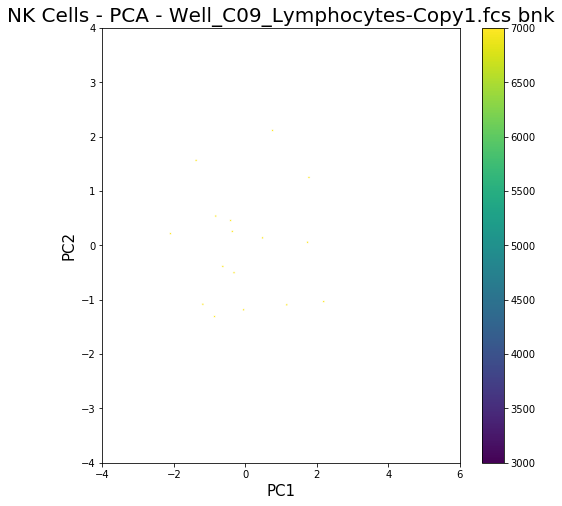

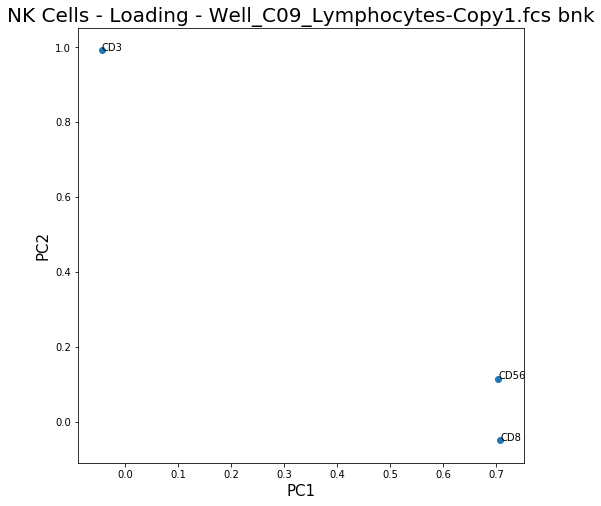

mean pStat activity:  13129.333


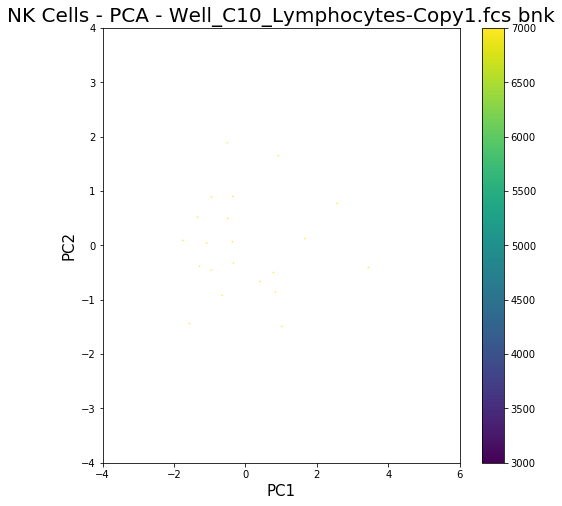

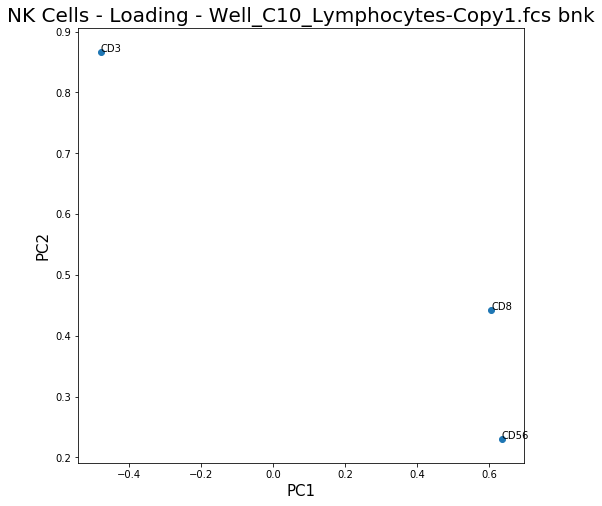

mean pStat activity:  11356.0


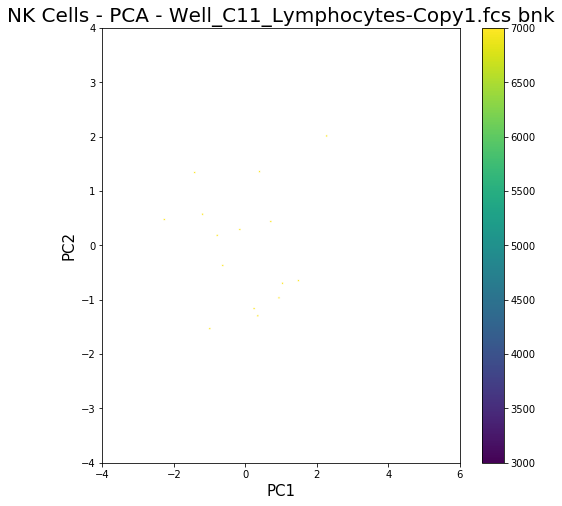

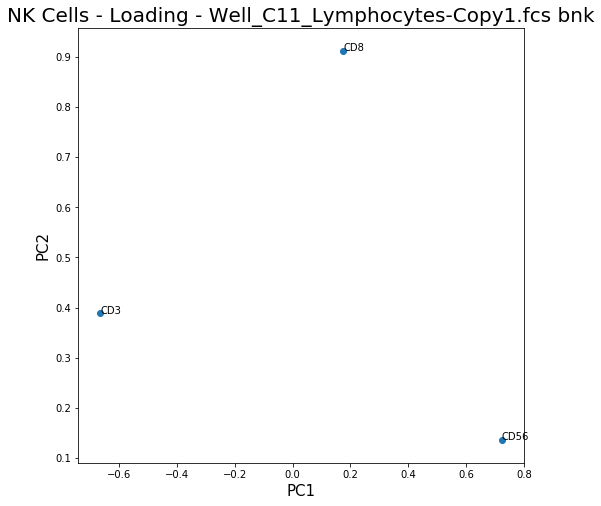

mean pStat activity:  12162.417


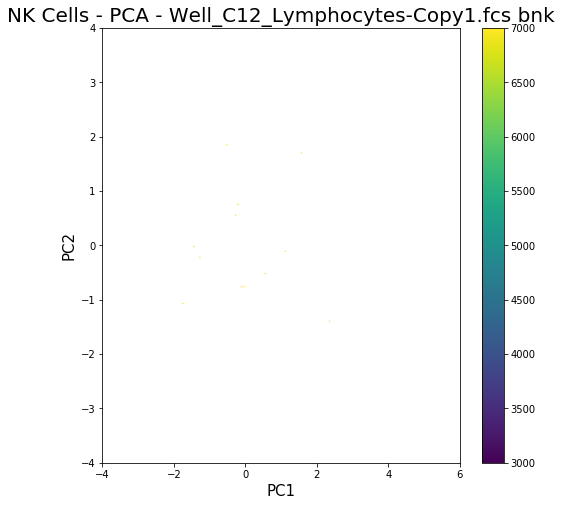

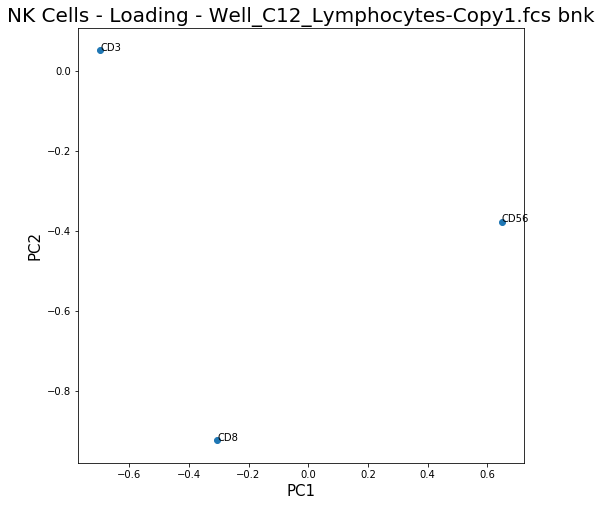

mean pStat activity:  4433.2017


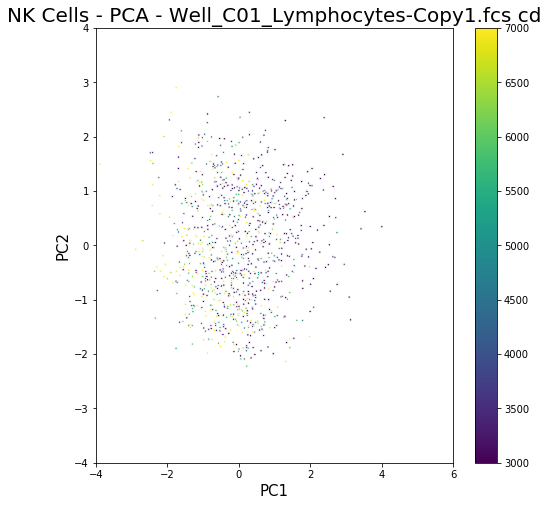

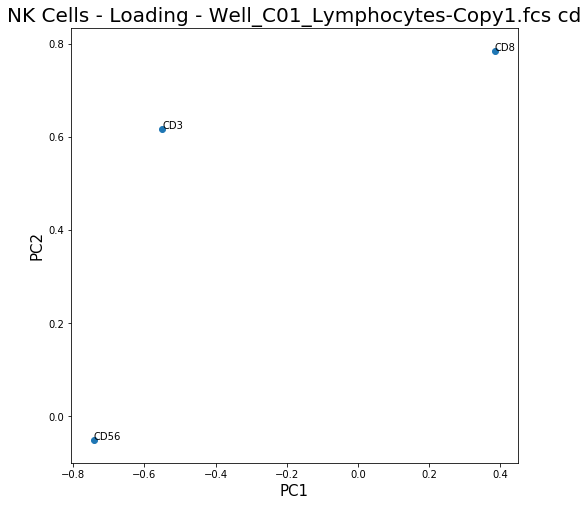

mean pStat activity:  4249.8086


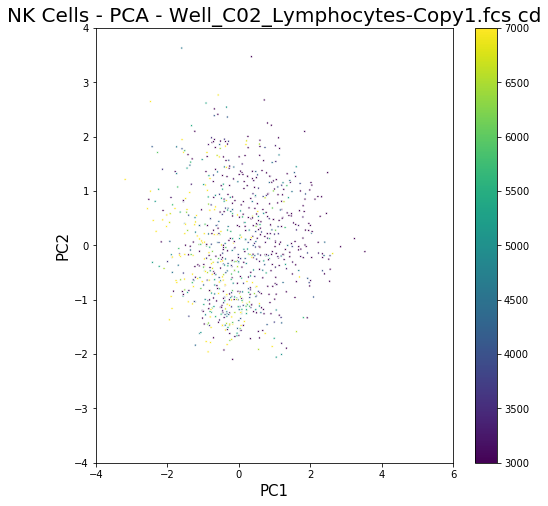

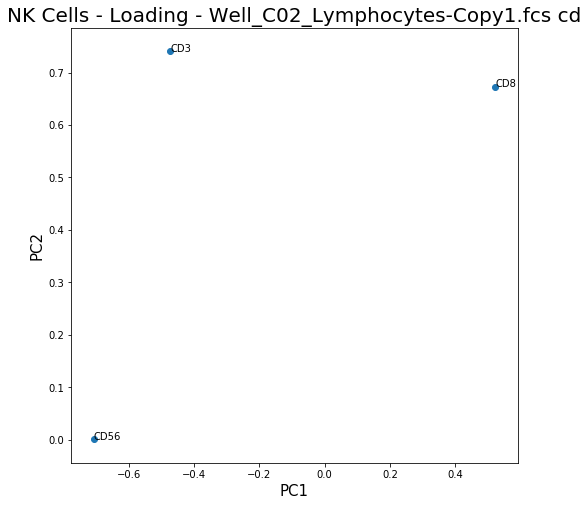

mean pStat activity:  3982.7778


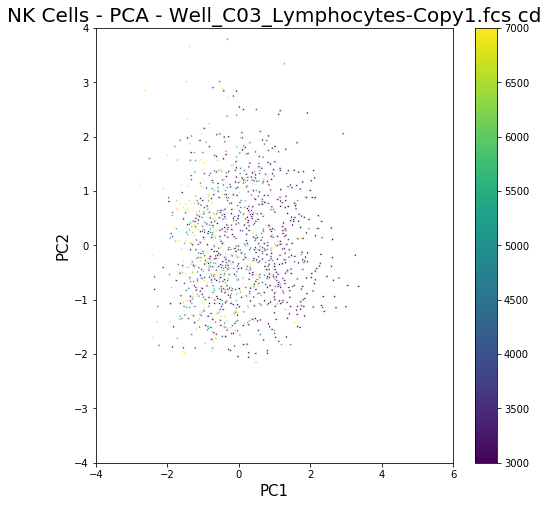

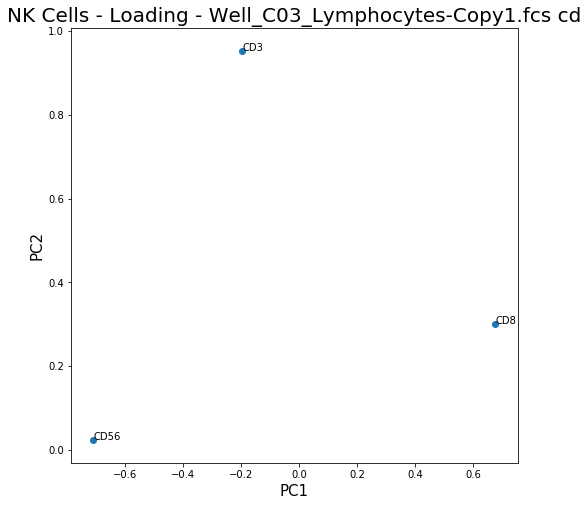

mean pStat activity:  2584.7415


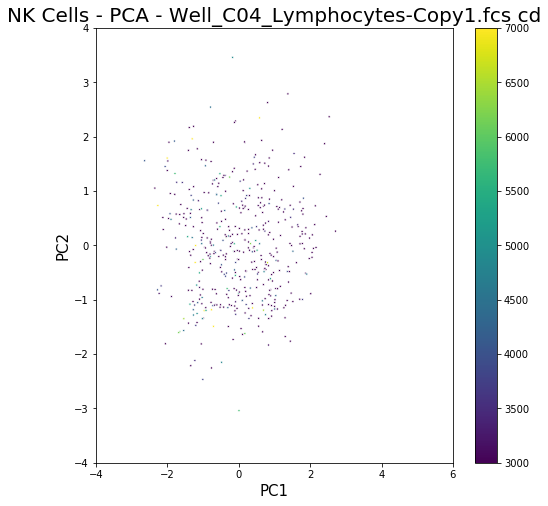

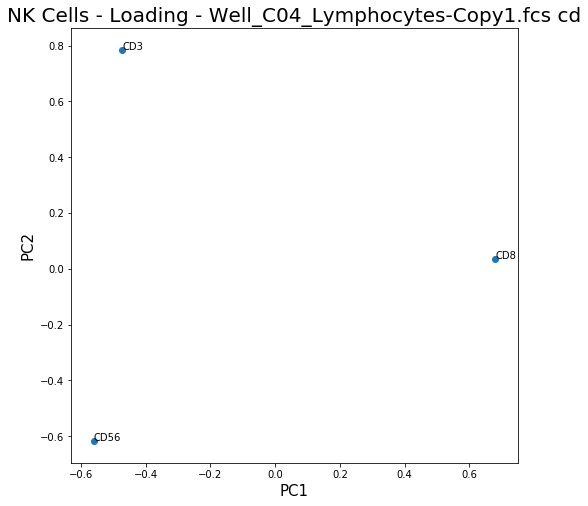

mean pStat activity:  1303.3759


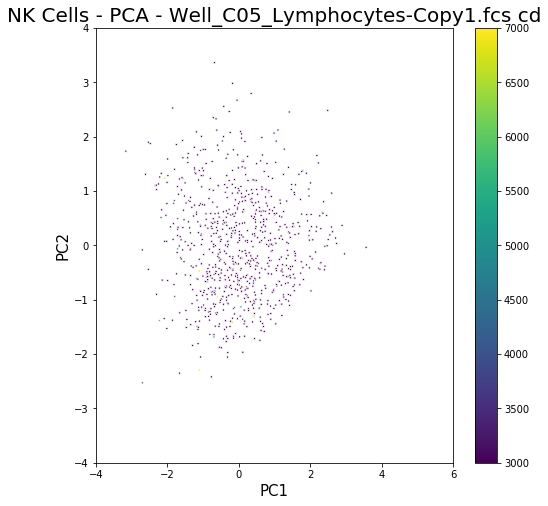

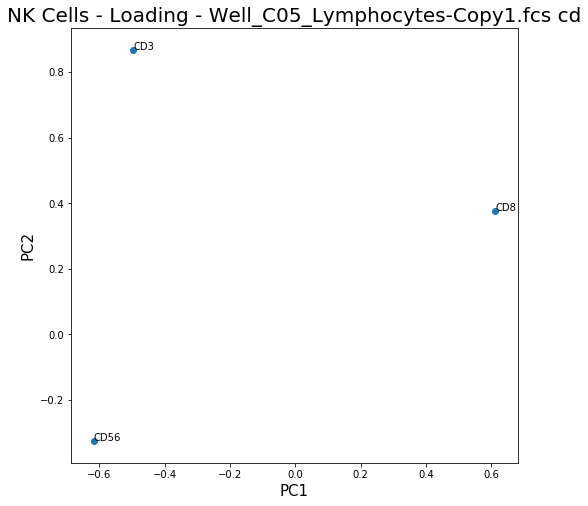

mean pStat activity:  1029.2198


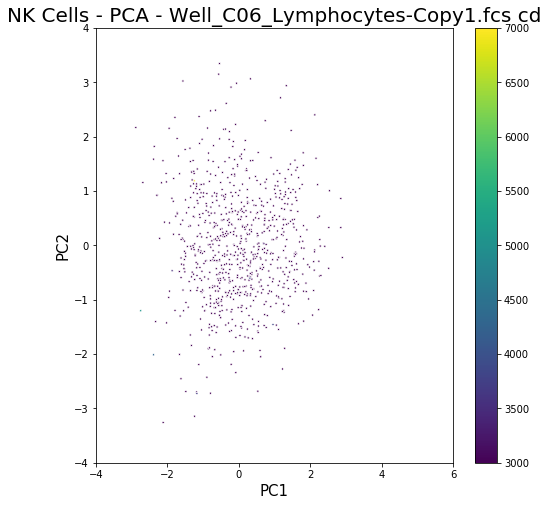

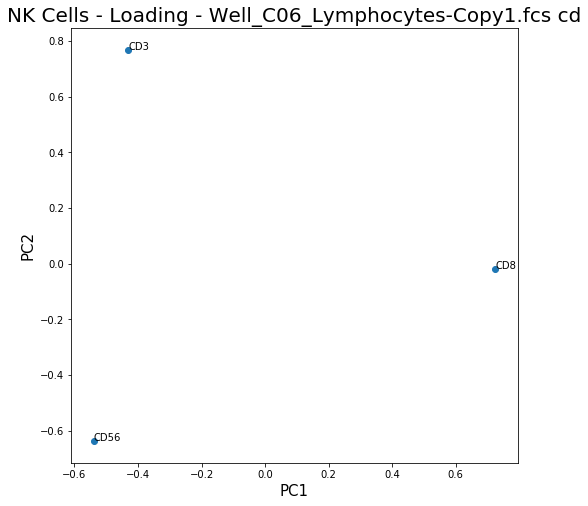

mean pStat activity:  1023.3471


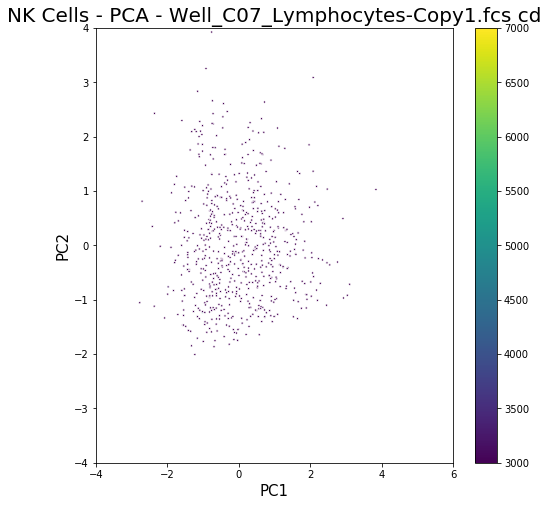

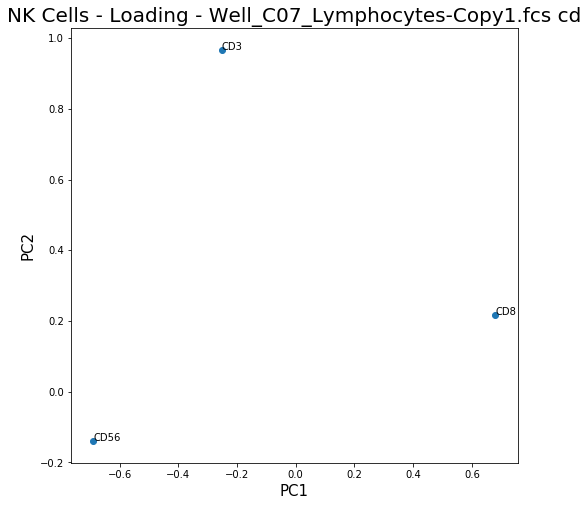

mean pStat activity:  992.3037


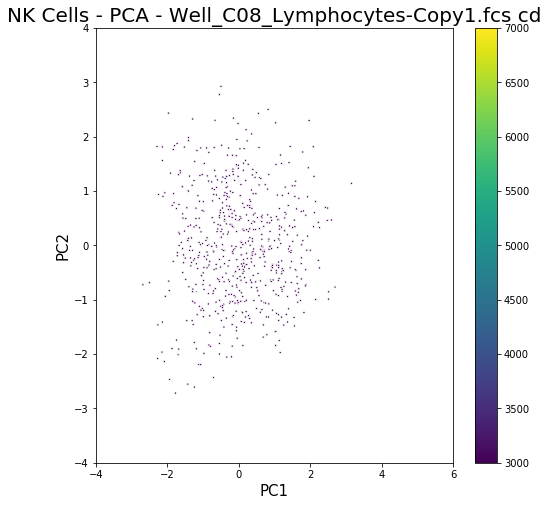

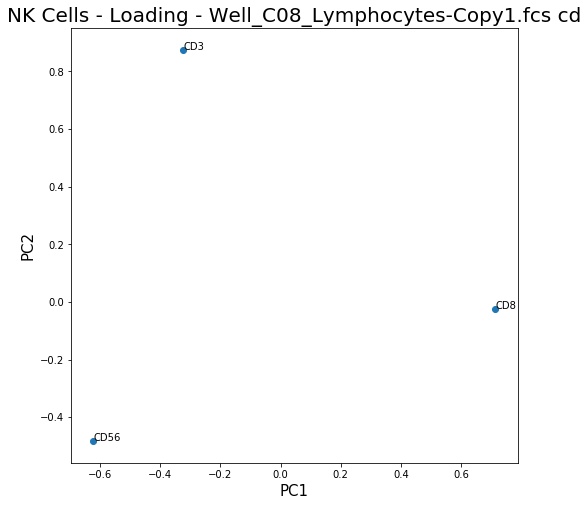

mean pStat activity:  1002.8929


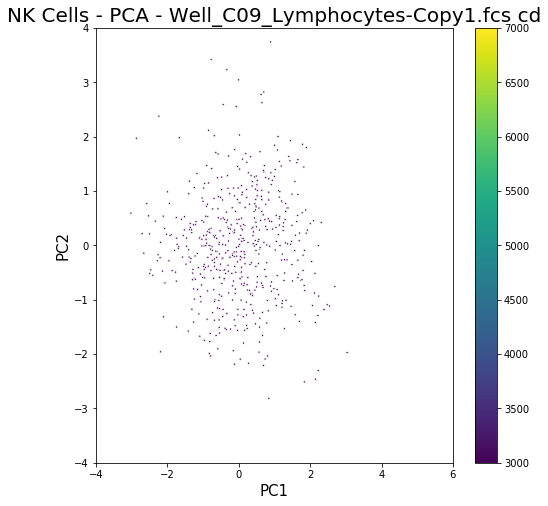

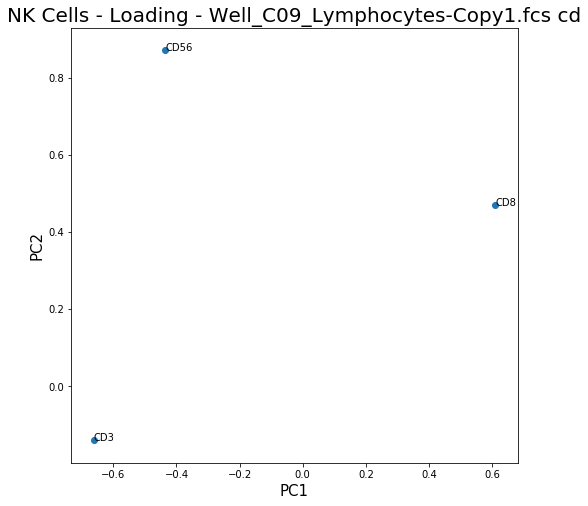

mean pStat activity:  1026.936


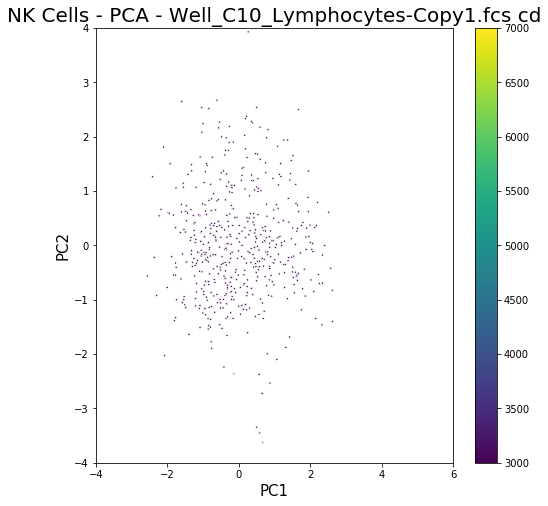

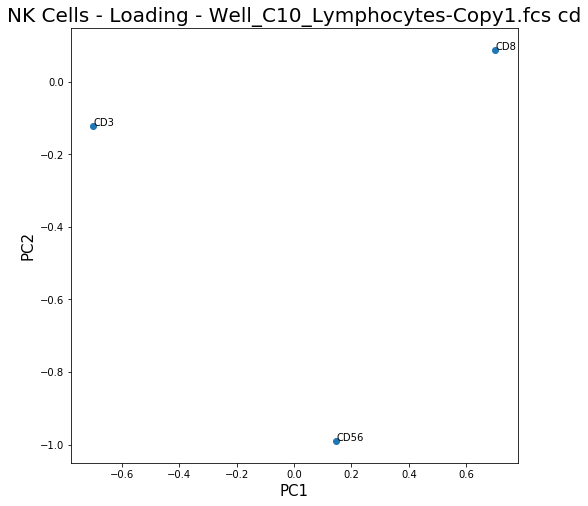

mean pStat activity:  1066.7784


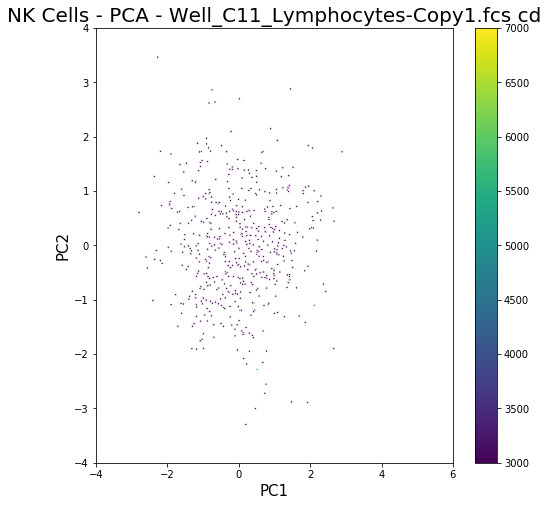

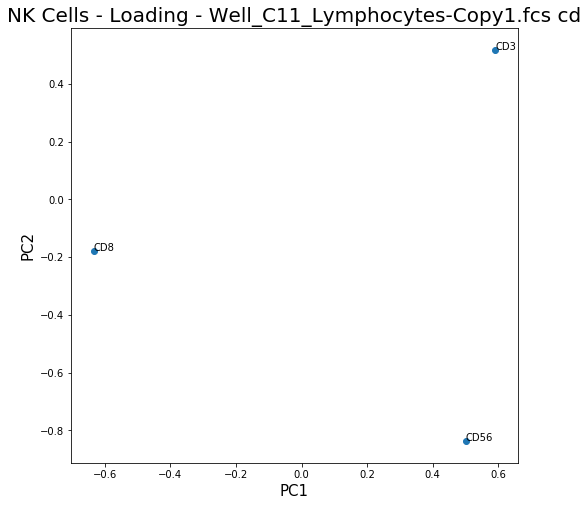

mean pStat activity:  1033.8864


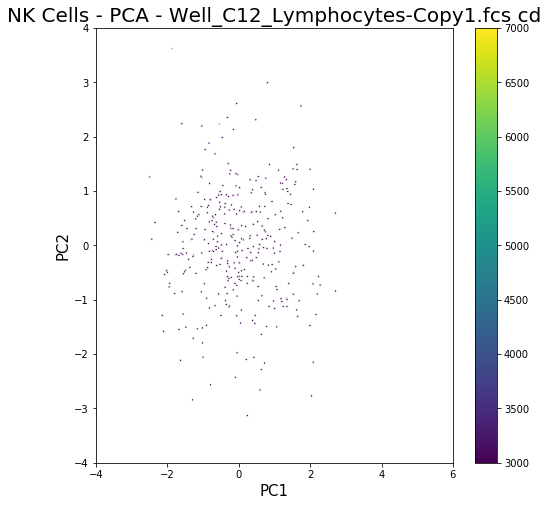

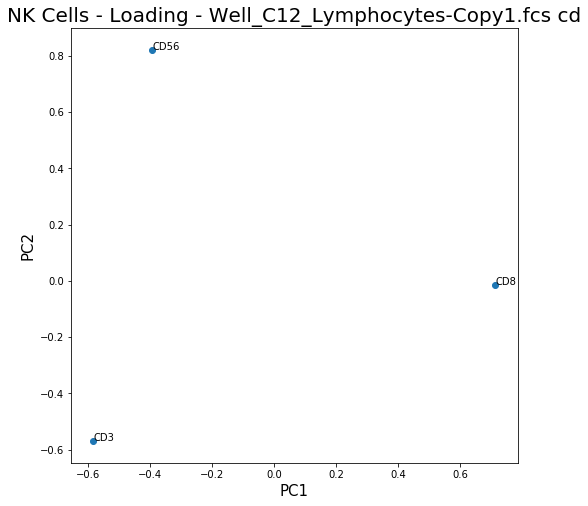

In [27]:
tplate = input('What is the name of the T plate folder?:')
tsample, titlesT = importF(tplate)

nkplate = input('What is the name of the NK plate folder?:')
nksample, titlesNK = importF(nkplate)

xfT_array, loadingT_array = pcaAllTypeSpec(tsample, "t", titlesT)

xfNK_array, loadingNK_array = pcaAllTypeSpec(nksample, "n", titlesNK)
#/home/brianoj/PosterPlatesT
